# **Load & Analyze Dataset**

### **Install Packages**

In [ ]:
pip install imbalanced-learn

In [ ]:
pip install shap scikit-learn matplotlib seaborn

In [ ]:
pip install shap

### **Import Libraries**

In [ ]:
# ==========================
# LOADING LIBRARIES
# ==========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================
# PREPROCESSING & UTILITIES
# ==========================
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from collections import Counter

# ==========================
# MODELING
# ==========================
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import xgboost as xgb


# ==========================
# EVALUATION
# ==========================
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)
from matplotlib.colors import ListedColormap

# ==========================
# VISUALIZATION
# ==========================
import seaborn as sns
import matplotlib.pyplot as plt



In [ ]:
pd.set_option('future.no_silent_downcasting', True)

In [ ]:
# Load the dataset
df = pd.read_csv("diabetic_data.csv", encoding="Windows-1252")


### **Drop duplicates**

In [ ]:
# Drop duplicate patients and keep first admission only
df = df.sort_values('encounter_id')  # Optional: sort for consistency
df = df.drop_duplicates(subset='patient_nbr', keep='first')


### **Filter age (20-50)**

In [ ]:
# Step 1: Filter age range 30-50
df = df[df['age'].isin(['[20-30)','[30-40)', '[40-50)'])]

In [ ]:
# Step 5: Save or preview the cleaned dataset
print(df.shape)  #3090,18
df

(10704, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
10,28236,89869032,AfricanAmerican,Female,[40-50),?,1,1,7,9,...,No,Steady,No,No,No,No,No,No,Yes,>30
12,40926,85504905,Caucasian,Female,[40-50),?,1,3,7,7,...,No,Down,No,No,No,No,No,Ch,Yes,<30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
28,250872,41606064,Caucasian,Male,[20-30),?,2,1,2,10,...,No,Down,No,No,No,No,No,Ch,Yes,>30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101740,443778398,134647673,Caucasian,Male,[40-50),?,3,1,1,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
101748,443811536,189481478,Caucasian,Female,[40-50),?,1,4,7,14,...,No,Down,No,No,No,No,No,Ch,Yes,>30
101752,443835512,139605341,Other,Female,[40-50),?,3,1,1,3,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
101753,443841992,184875899,Other,Male,[40-50),?,1,1,7,13,...,No,Down,No,No,No,No,No,Ch,Yes,NO


In [ ]:
for column in df.columns:
    unique_values = df[column].unique()
    print(f"'{column}':\n{unique_values}\n")


'encounter_id':
[    16680     28236     40926 ... 443835512 443841992 443842022]

'patient_nbr':
[ 42519267  89869032  85504905 ... 139605341 184875899 188574944]

'race':
['Caucasian' 'AfricanAmerican' '?' 'Other' 'Hispanic' 'Asian']

'gender':
['Male' 'Female']

'age':
['[40-50)' '[20-30)' '[30-40)']

'weight':
['?' '[75-100)' '[0-25)' '[50-75)' '[100-125)' '[125-150)' '>200'
 '[25-50)' '[150-175)' '[175-200)']

'admission_type_id':
[1 2 3 6 5 8 4 7]

'discharge_disposition_id':
[ 1  3  6 25 11  2  7  5 18  8 14  4 17 16 23 22 13 28 15]

'admission_source_id':
[ 7  2  4  1  6 20 17  8  3  5  9 10 11]

'time_in_hospital':
[ 1  9  7  2 10  8  3  4  6 11 14  5 13 12]

'payer_code':
['?' 'HM' 'MC' 'UN' 'BC' 'SI' 'MD' 'CP' 'SP' 'CH' 'DM' 'PO' 'WC' 'OG' 'CM'
 'OT' 'MP']

'medical_specialty':
['?' 'Family/GeneralPractice' 'Cardiology' 'Gastroenterology'
 'InternalMedicine' 'Psychiatry' 'Obsterics&Gynecology-GynecologicOnco'
 'ObstetricsandGynecology' 'Orthopedics-Reconstructive' 'Nephrolog

# **Data Preprocessing & EDA**

### **Drop Missing Column**

In [ ]:
# Checking for '?' as missing values in object columns of df2
for col in df.columns:
    if df[col].dtype == object:
        missing_count = df[col][df[col] == '?'].count()
        if missing_count > 0:
            print(f"{col}: {missing_count}")


race: 307
weight: 10367
payer_code: 4795
medical_specialty: 4928
diag_1: 2
diag_2: 71
diag_3: 419


In [ ]:
#Check for missing data
df.isnull().sum()

,0
encounter_id,0
patient_nbr,0
race,0
gender,0
age,0
weight,0
admission_type_id,0
discharge_disposition_id,0
admission_source_id,0
time_in_hospital,0


In [ ]:
#dropping columns with large number of missing values

df = df.drop(['weight','payer_code','medical_specialty'], axis = 1)
df = df.drop(['citoglipton', 'examide' ], axis = 1) #only have one categories, redundancy

### **Feature Engineering**

In [ ]:
# Drop rare invalid gender entries
df = df[df['gender'] != 'Unknown/Invalid']

# Drop rows where discharge_disposition_id = 11 (expired/died)
df = df[df['discharge_disposition_id'] != 11]

# Replace '?' in race with mode
df['race'] = df['race'].replace('?', df['race'].mode()[0])

# Replace '?' with mode for diag_1 and diag_2
df['diag_1'] = df['diag_1'].replace('?', df['diag_1'].mode()[0])
df['diag_2'] = df['diag_2'].replace('?', df['diag_2'].mode()[0])

# For diag_3, use 'Unknown' (optional: for ICD grouping or to avoid mode bias)
df['diag_3'] = df['diag_3'].replace('?', 'Unknown')

In [ ]:
# Replace '?' with 'None' to reflect missing test result
df['A1Cresult'] = df['A1Cresult'].replace('?', 'None')
df['max_glu_serum'] = df['max_glu_serum'].replace('?', 'None')

In [ ]:
meds = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide', 'metformin-pioglitazone','metformin-rosiglitazone',
        'glimepiride-pioglitazone', 'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']

for col in meds:
    colname = str(col) + 'temp'
    df[colname] = df[col].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)

df['medch'] = 0
for col in meds:
    colname = str(col) + 'temp'
    df['medch'] += df[colname]
    del df[colname]

df['medch'].value_counts()

,count
medch,
0,7406
1,3072
2,158
3,18


In [ ]:
# Step 5: Binary and ordinal encodings
df['change'] = df['change'].map({'Ch': 1, 'No': 0}).fillna(0).astype(int)
df['diabetesMed'] = df['diabetesMed'].map({'Yes': 1, 'No': 0}).fillna(0).astype(int)

df['A1Cresult'] = df['A1Cresult'].map({'None': 0, 'Norm': 1, '>7': 2, '>8': 3}).fillna(0).astype(int)
df['max_glu_serum'] = df['max_glu_serum'].map({'None': 0, 'Norm': 1, '>200': 2, '>300': 3}).fillna(0).astype(int)

# Identify medication columns and encode
meds = [col for col in df.columns if set(df[col].unique()) <= set(['No', 'Steady', 'Up', 'Down'])]
for col in meds:
    df[col] = df[col].replace({'No': 0, 'Steady': 1, 'Up': 1, 'Down': 1})

In [ ]:
# Step 1: Convert to string to detect 'V' or 'E', then set them to 0
for col in ['diag_1', 'diag_2', 'diag_3']:
    df[col] = df[col].replace('Unknown', '0')  # fix invalid strings
    df[col] = df[col].astype(str)
    df.loc[df[col].str.startswith(('V', 'E')), col] = '0'
    df[col] = df[col].astype(float)

# Step 2: Define mapping function
def map_icd9_category(code):
    if code == -99:
        return 0  # Unclassified / V/E/Missing
    elif (390 <= code < 460) or int(code) == 785:
        return 1  # Circulatory
    elif (460 <= code < 520) or int(code) == 786:
        return 2  # Respiratory
    elif (520 <= code < 580) or int(code) == 787:
        return 3  # Digestive
    elif int(code) == 250:
        return 4  # Diabetes
    elif 800 <= code < 1000:
        return 5  # Injury
    elif 710 <= code < 740:
        return 6  # Musculoskeletal
    elif (580 <= code < 630) or int(code) == 788:
        return 7  # Genitourinary
    elif 140 <= code < 240:
        return 8  # Neoplasms
    else:
        return 0  # Other/Unclassified

# Step 3: Apply mapping
for col in ['diag_1', 'diag_2', 'diag_3']:
    df[col] = df[col].apply(map_icd9_category).astype(int)


In [ ]:
# Re-encoding admission_type_id
df['admission_type_id'] = df['admission_type_id'].replace({
    2: 1, 7: 1, # Emergency or urgent → grouped as 1
    6: 5, 8: 5 # Unknown or null → grouped as 5 (other)
})

# Re-encoding discharge_disposition_id
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace({
    6: 1, 8: 1, 9: 1, 13: 1, # Still in hospital, or short-term care
    3: 2, 4: 2, 5: 2, 14: 2, 22: 2, 23: 2, 24: 2, # Transferred to another facility
    12: 10, 15: 10, 16: 10, 17: 10, # Hospice
    25: 18, 26: 18 # Other unknown categories
})

# Re-encoding admission_source_id
df['admission_source_id'] = df['admission_source_id'].replace({
    2: 1, 3: 1, # Referral from another provider
    5: 4, 6: 4, 10: 4, 22: 4, 25: 4, # Emergency room or clinic
    15: 9, 17: 9, 20: 9, 21: 9, # Unknown or not available
    13: 11, 14: 11  # Court/law enforcement or other rare source
})

In [ ]:
# Encode readmitted column safely using .loc
y = df['readmitted'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0).astype(int)

In [ ]:
df['age'] = df['age'].replace({
    '[20-30)': 2,
    '[30-40)': 3,
    '[40-50)': 4,
}).astype(int)

In [ ]:
df['visit_history'] = (
    df['number_outpatient'] +
    df['number_emergency'] +
    df['number_inpatient']
)

In [ ]:
# Define high-risk diagnosis categories
high_risk_codes = [1, 2, 4, 8]

# Create risk flag: 1 if any of the three diagnosis columns is high risk
df['chronic_risk'] = df[['diag_1', 'diag_2', 'diag_3']].apply(
    lambda row: int(any(cat in high_risk_codes for cat in row)), axis=1
)

In [ ]:
#Check for missing data
df.isnull().sum()

,0
encounter_id,0
patient_nbr,0
race,0
gender,0
age,0
admission_type_id,0
discharge_disposition_id,0
admission_source_id,0
time_in_hospital,0
num_lab_procedures,0


# **Data Visualization**

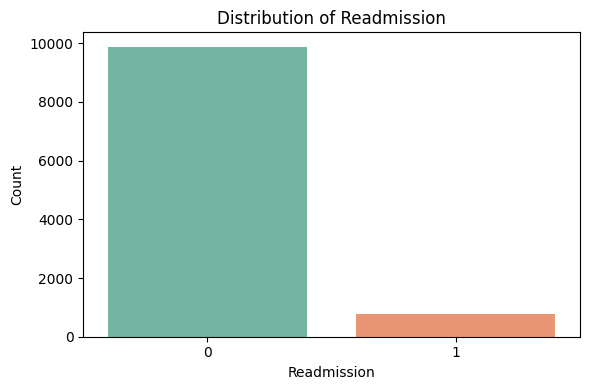

In [ ]:
# Distribution of Readmission

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='readmitted', hue='readmitted', palette='Set2', legend=False)
plt.title('Distribution of Readmission')
plt.xlabel('Readmission')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Age of Patient VS. Readmission')

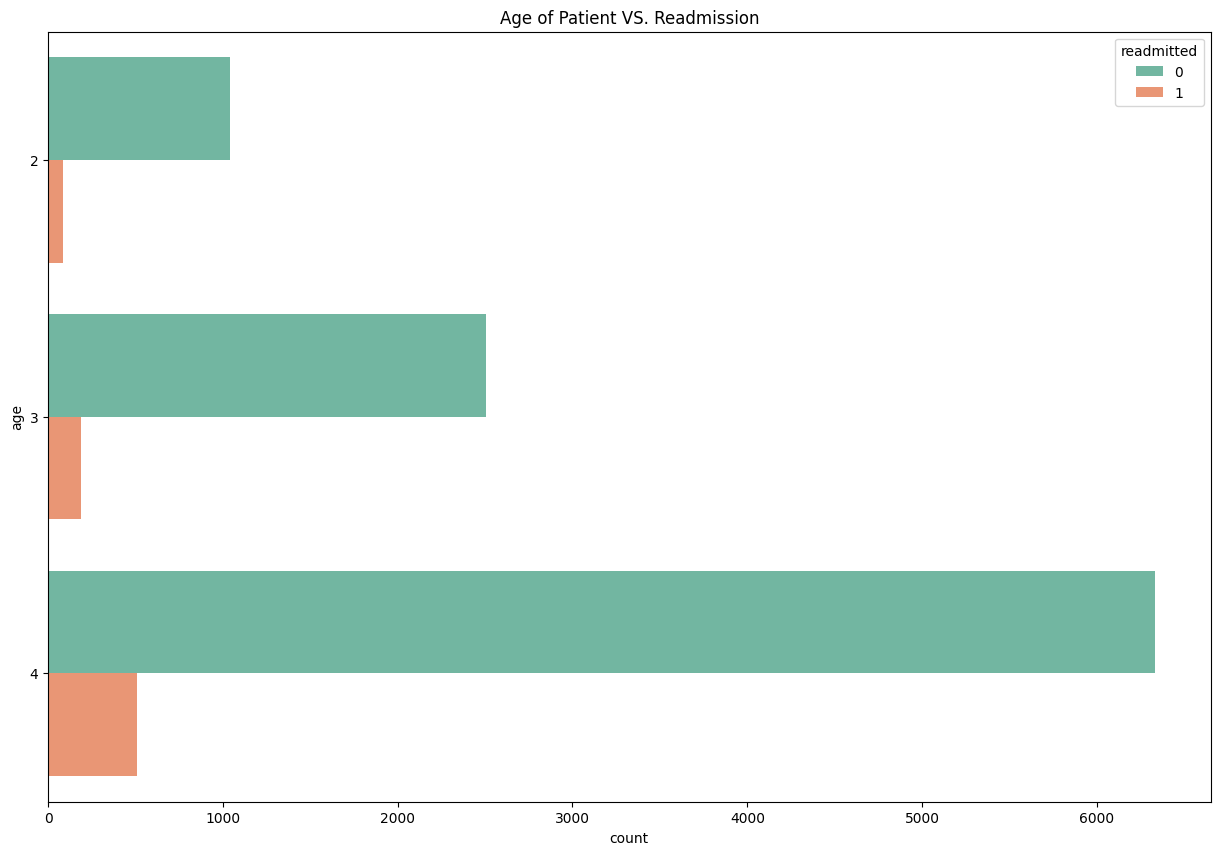

In [ ]:
# Plot 1: Age vs Readmission
fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(y='age', hue='readmitted', data=df, palette='Set2', ax=ax)
ax.set_title('Age of Patient VS. Readmission')

Text(0.5, 1.0, 'Race VS. Readmission')

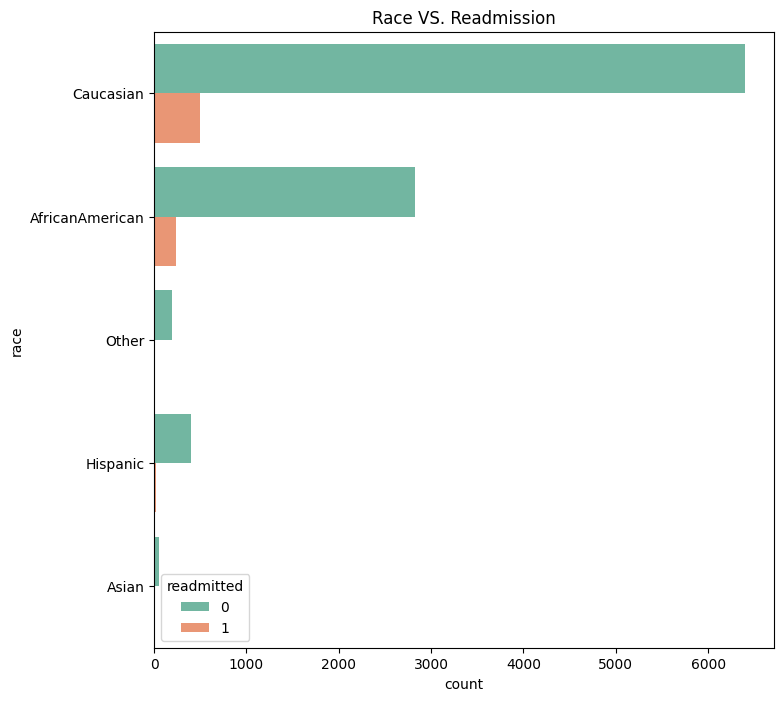

In [ ]:
# Plot 2: Race vs Readmission
fig, ax = plt.subplots(figsize=(8, 8))
sns.countplot(y='race', hue='readmitted', data=df, palette='Set2', ax=ax)
ax.set_title('Race VS. Readmission')

Text(0, 0.5, 'Number of Medications')

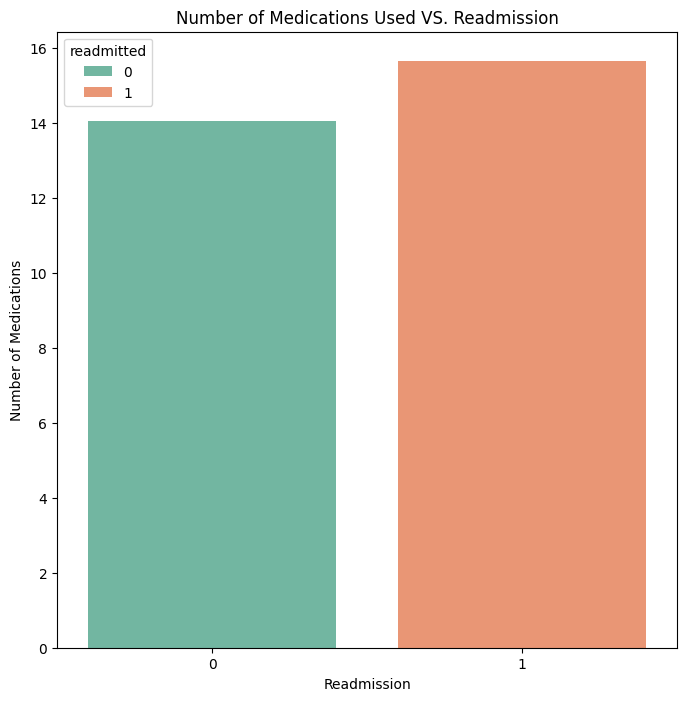

In [ ]:
# Plot 3: Number of medications
fig, ax = plt.subplots(figsize=(8, 8))
sns.barplot(
    y='num_medications',
    x='readmitted',
    hue='readmitted',
    data=df,
    palette='Set2',
    ax=ax,
    errorbar=None
)
ax.set_title("Number of Medications Used VS. Readmission")
ax.set_xlabel("Readmission")
ax.set_ylabel("Number of Medications")

Text(0.5, 1.0, 'Gender of Patient VS. Readmission')

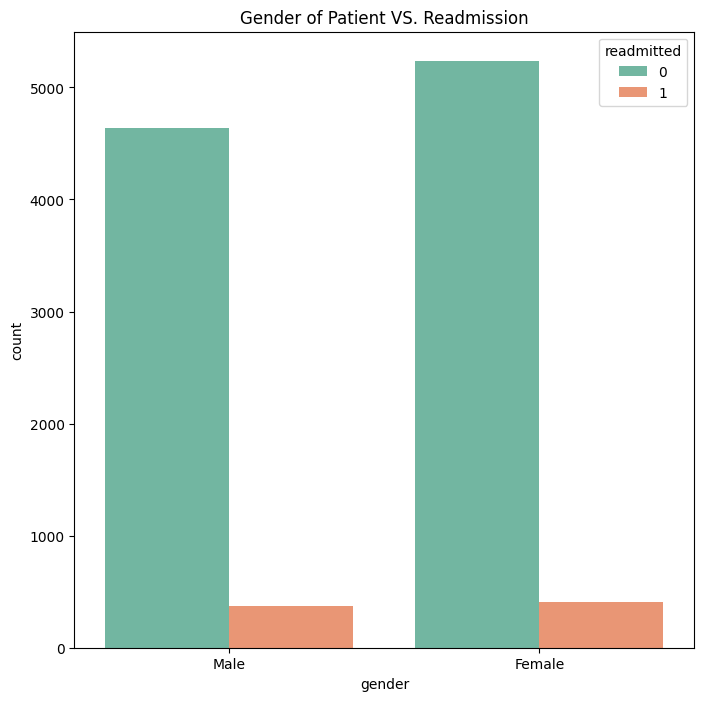

In [ ]:
# Plot 4: Gender vs Readmission
fig, ax = plt.subplots(figsize=(8, 8))
sns.countplot(x='gender', hue='readmitted', data=df, palette='Set2', ax=ax)
ax.set_title("Gender of Patient VS. Readmission")

Text(0.5, 1.0, 'Diabetes Medication Prescribed VS. Readmission')

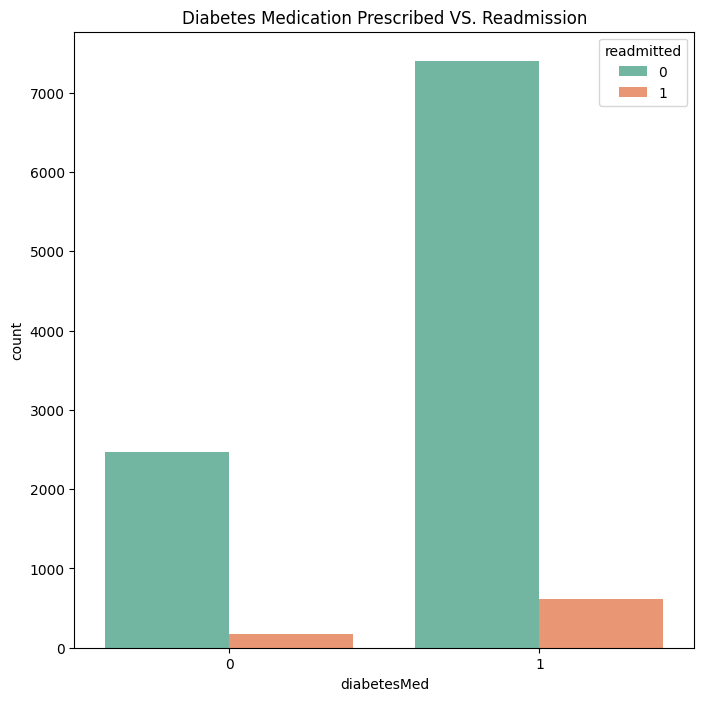

In [ ]:
# Plot 6: Diabetes medication prescribed
fig, ax = plt.subplots(figsize=(8, 8))
sns.countplot(x='diabetesMed', hue='readmitted', data=df, palette='Set2', ax=ax)
ax.set_title('Diabetes Medication Prescribed VS. Readmission')

Text(0.5, 1.0, 'Change of Medication VS. Readmission')

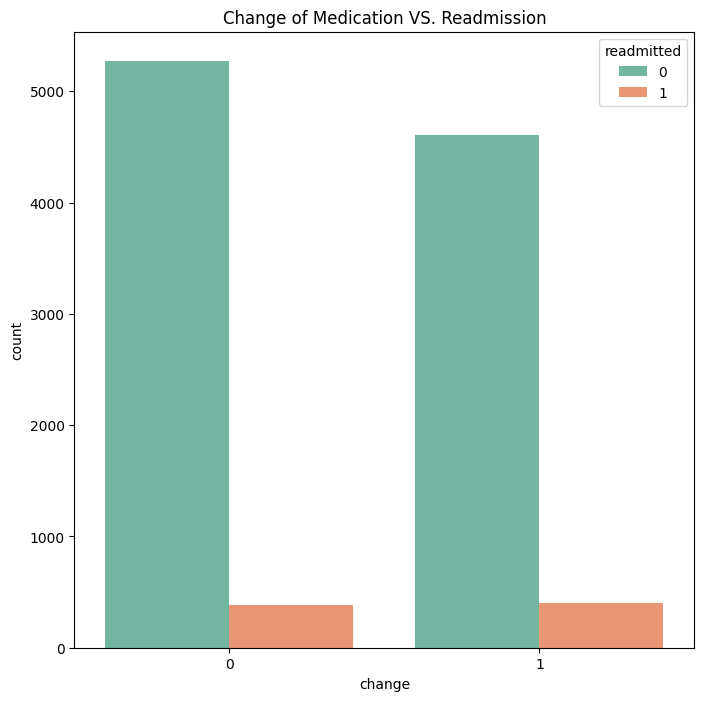

In [ ]:
# Plot 5: Change of medication
fig, ax = plt.subplots(figsize=(8, 8))
sns.countplot(x='change', hue='readmitted', data=df, palette='Set2', ax=ax)
ax.set_title('Change of Medication VS. Readmission')

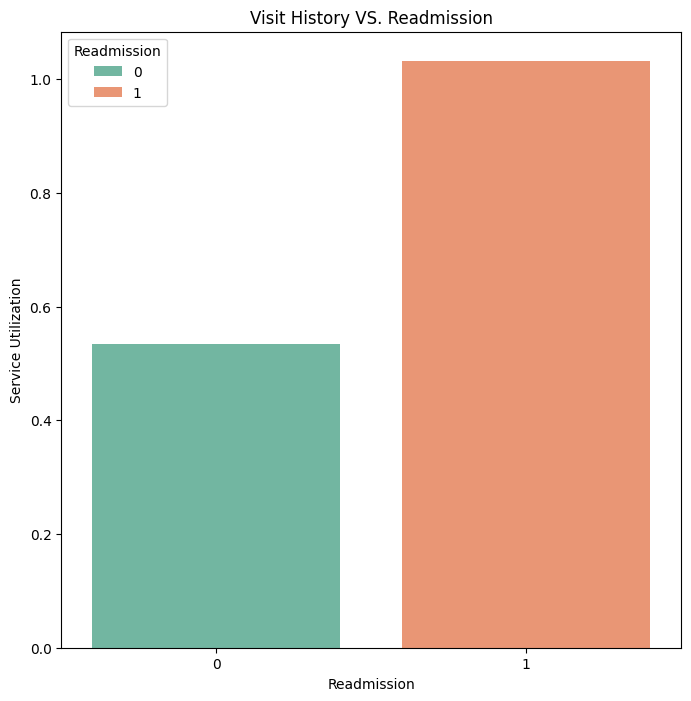

In [ ]:
# Plot 7: Service utilization
fig, ax = plt.subplots(figsize=(8, 8))
sns.barplot(
    y='visit_history',
    x='readmitted',
    hue='readmitted',  # add hue
    data=df,
    palette='Set2',
    ax=ax,
    errorbar=None
)
ax.set_title("Visit History VS. Readmission")
ax.set_xlabel("Readmission")
ax.set_ylabel("Service Utilization")
ax.legend(title="Readmission")

Text(0.5, 1.0, 'Glucose Serum Test Result VS. Readmission')

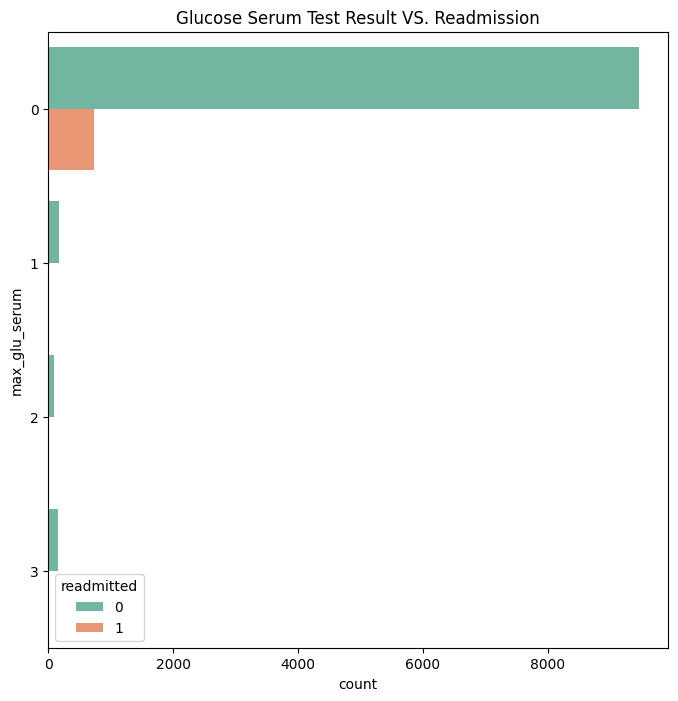

In [ ]:
# Plot 8: Glucose serum test result
fig, ax = plt.subplots(figsize=(8, 8))
sns.countplot(y='max_glu_serum', hue='readmitted', data=df, palette='Set2', ax=ax)
ax.set_title('Glucose Serum Test Result VS. Readmission')

Text(0.5, 1.0, 'A1C Test Result VS. Readmission')

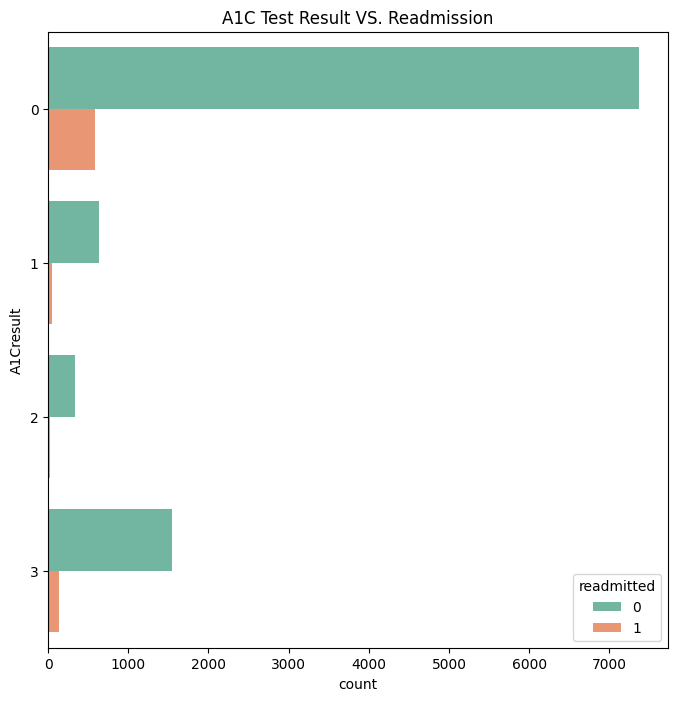

In [ ]:
# Plot 9: A1C test result
fig, ax = plt.subplots(figsize=(8, 8))
sns.countplot(y='A1Cresult', hue='readmitted', data=df, palette='Set2', ax=ax)
ax.set_title('A1C Test Result VS. Readmission')

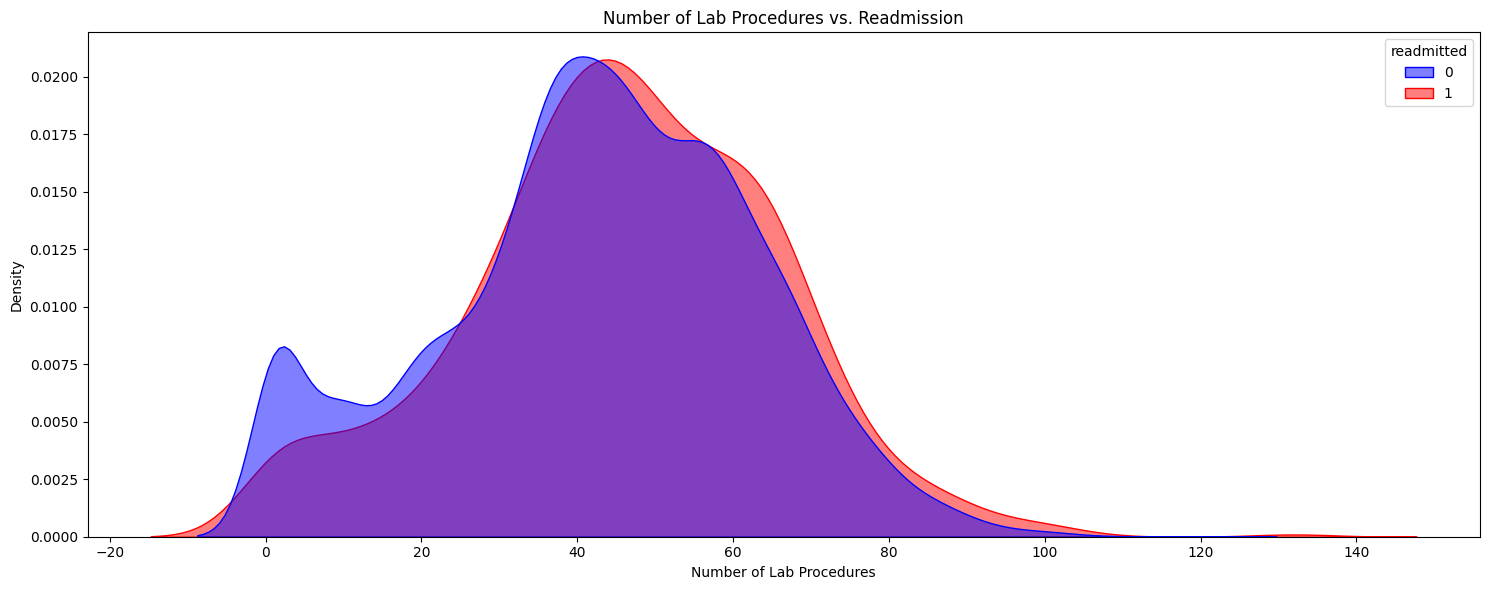

In [ ]:
# Tim in Hospital vs. Readmission
plt.figure(figsize=(15, 6))
sns.kdeplot(
    data=df,
    x='num_lab_procedures',
    hue='readmitted',
    fill=True,
    common_norm=False,
    palette={0: 'blue', 1: 'red'},
    alpha=0.5
)

plt.xlabel('Number of Lab Procedures')
plt.ylabel('Density')
plt.title('Number of Lab Procedures vs. Readmission')
plt.tight_layout()
plt.show()

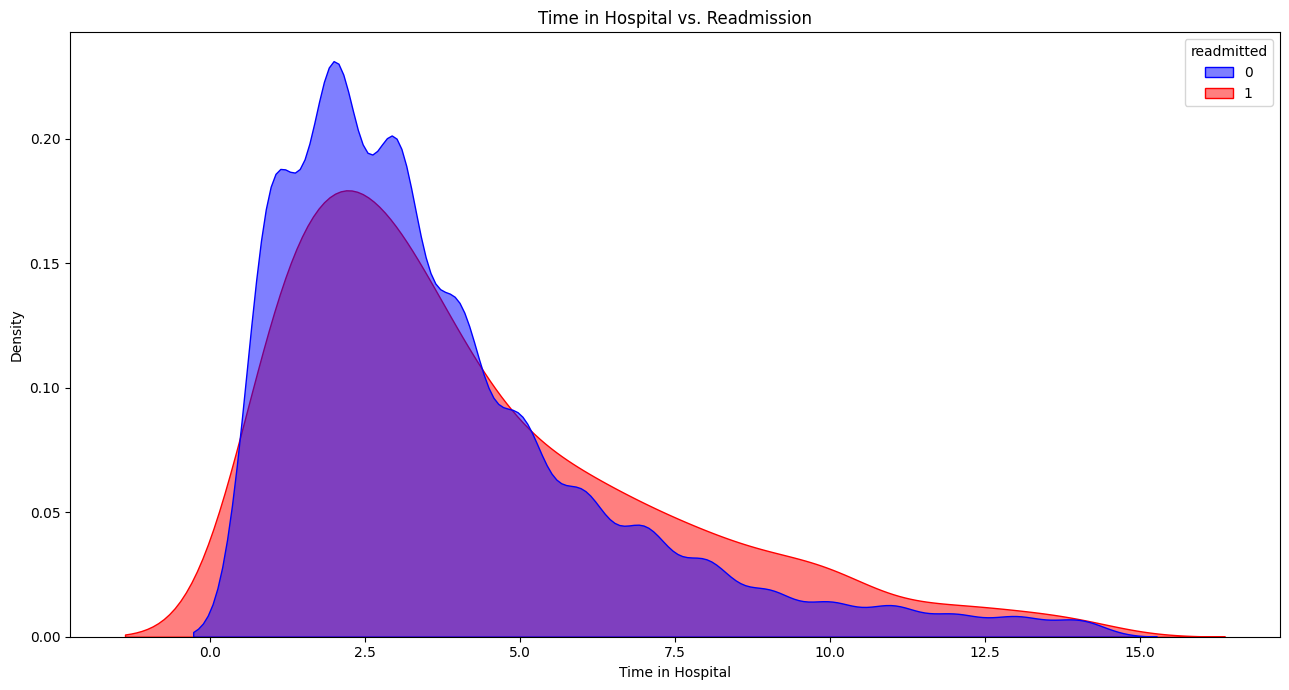

In [ ]:
# Tim in Hospital vs. Readmission
plt.figure(figsize=(13, 7))
sns.kdeplot(
    data=df,
    x='time_in_hospital',
    hue='readmitted',
    fill=True,
    common_norm=False,
    palette={0: 'blue', 1: 'red'},
    alpha=0.5
)

plt.xlabel('Time in Hospital')
plt.ylabel('Density')
plt.title('Time in Hospital vs. Readmission')
plt.tight_layout()
plt.show()

# **Pre-Modelling**

### **Apply log transformation for skew data**

In [ ]:
# Simulated numeric columns
num_col = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'num_medications', 'number_outpatient', 'number_emergency',
    'number_inpatient', 'number_diagnoses',  'medch', 'visit_history'
]

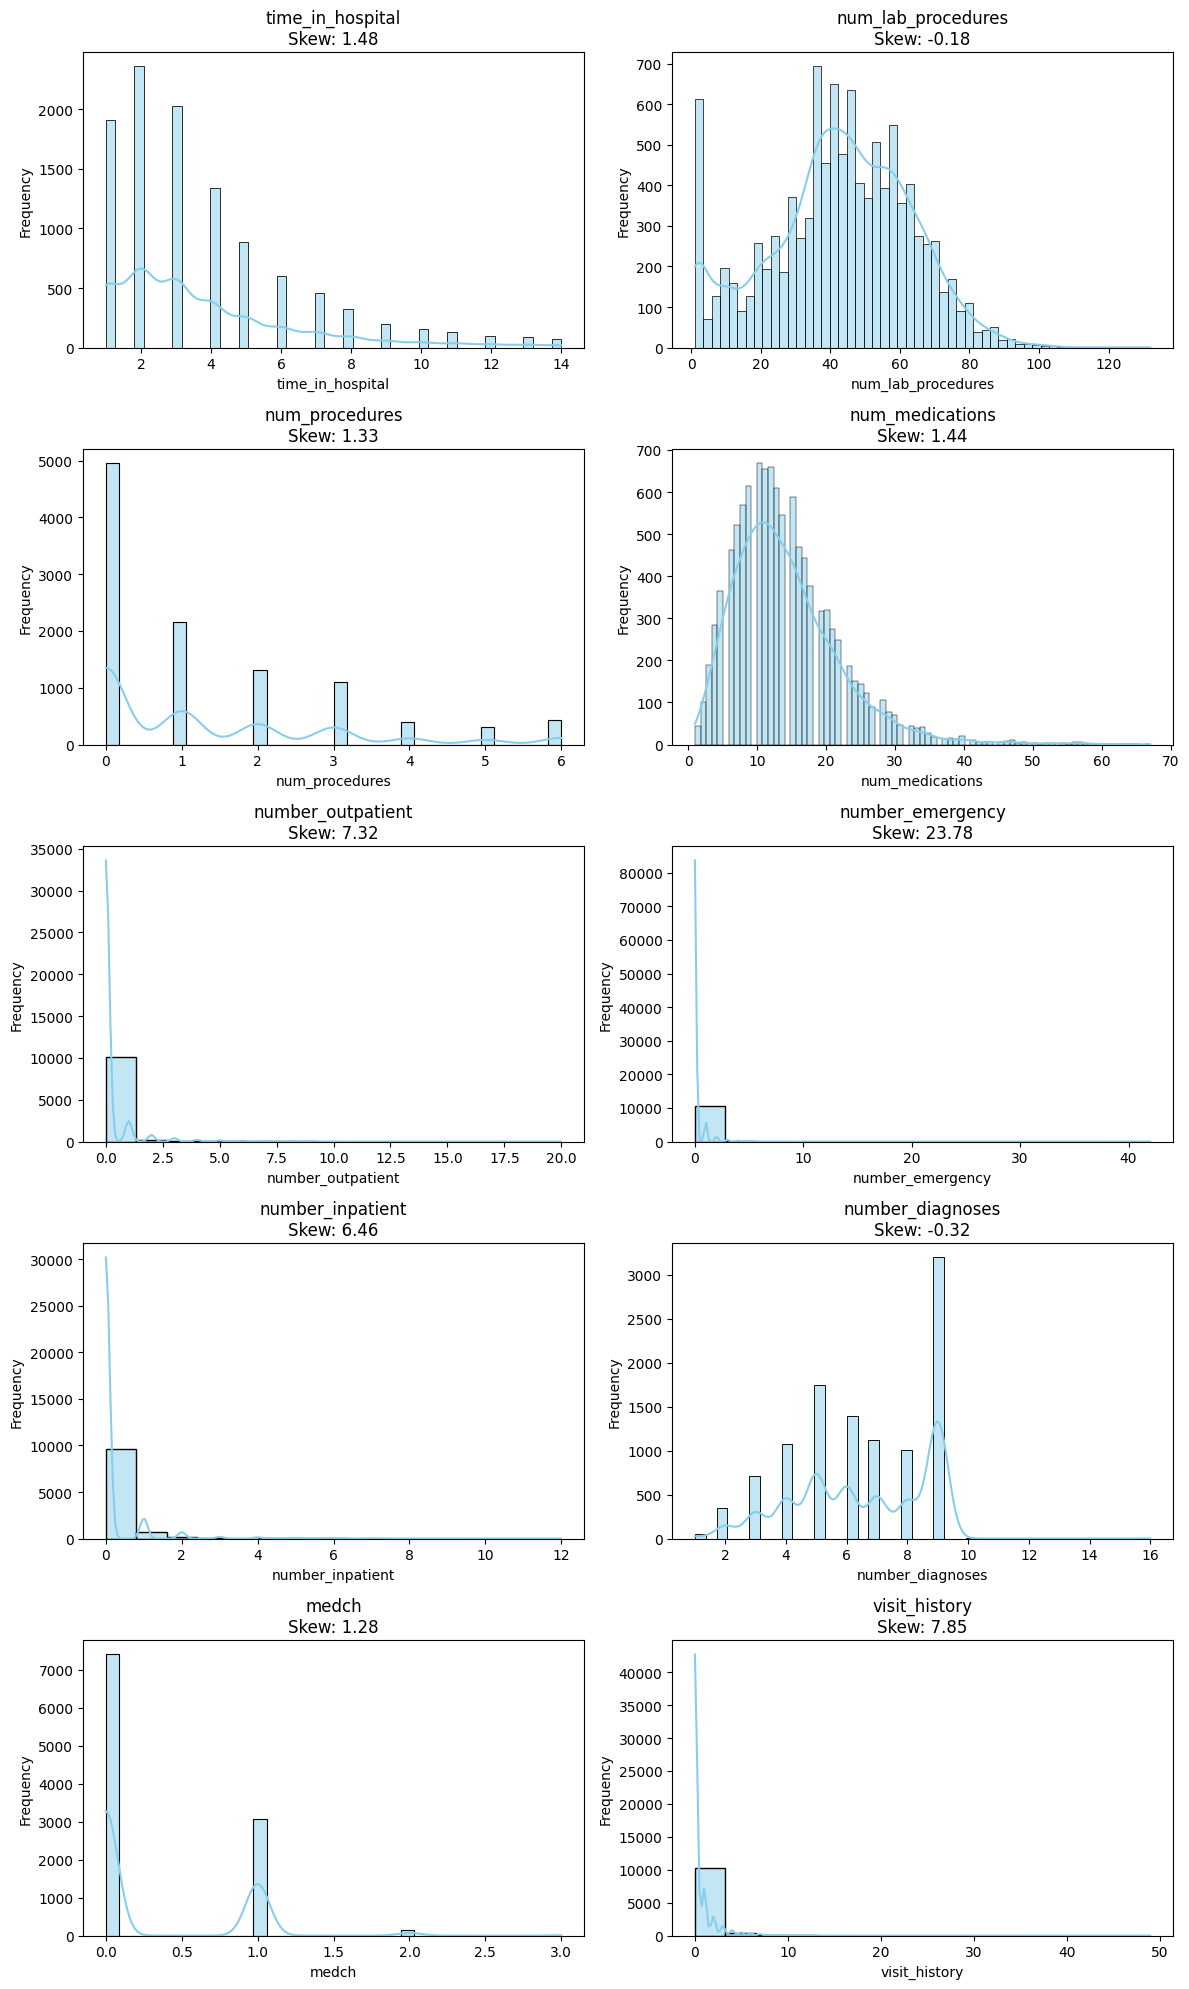

In [ ]:
# set up the layout
ncols = 2
nrows = int(np.ceil(len(num_col) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, nrows * 4))

# flatten axes for easy indexing
axes = axes.flatten()

for idx, col in enumerate(num_col):
    sns.histplot(df[col], kde=True, ax=axes[idx], color='skyblue')
    axes[idx].set_title(f"{col}\nSkew: {df[col].skew():.2f}")
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel("Frequency")

# if extra axes, turn them off
for j in range(idx + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
# Initialize the stats tracking dataframe
statdataframe = pd.DataFrame()
statdataframe['numeric_column'] = num_col

# Initialize lists to track statistics
skew_before, skew_after = [], []
kurt_before, kurt_after = [], []
standard_deviation_before, standard_deviation_after = [], []
log_transform_needed, log_type = [], []


# Loop through each numeric column
for col in num_col:
    skewval = df[col].skew()
    kurtval = df[col].kurtosis()
    sdval = df[col].std()

    skew_before.append(skewval)
    kurt_before.append(kurtval)
    standard_deviation_before.append(sdval)

    if abs(skewval) > 2 and abs(kurtval) > 2:
        log_transform_needed.append('Yes')
        if (df[col] == 0).sum() / len(df) <= 0.02:
            log_type.append('log')
            df[col] = np.log(df[col].replace(0, np.nan)).fillna(0)
        else:
            log_type.append('log1p')
            df[col] = np.log1p(df[col])

        skew_after.append(df[col].skew())
        kurt_after.append(df[col].kurtosis())
        standard_deviation_after.append(df[col].std())
    else:
        log_transform_needed.append('No')
        log_type.append('NA')
        skew_after.append(skewval)
        kurt_after.append(kurtval)
        standard_deviation_after.append(sdval)

# Store stats in summary dataframe
statdataframe['skew_before'] = skew_before
statdataframe['kurtosis_before'] = kurt_before
statdataframe['standard_deviation_before'] = standard_deviation_before
statdataframe['log_transform_needed'] = log_transform_needed
statdataframe['log_type'] = log_type
statdataframe['skew_after'] = skew_after
statdataframe['kurtosis_after'] = kurt_after
statdataframe['standard_deviation_after'] = standard_deviation_after

In [ ]:
statdataframe

,numeric_column,skew_before,kurtosis_before,standard_deviation_before,log_transform_needed,log_type,skew_after,kurtosis_after,standard_deviation_after
0,time_in_hospital,1.478337,2.132236,2.708289,No,NA,1.478337,2.132236,2.708289
1,num_lab_procedures,-0.180920,-0.301615,20.458498,No,NA,-0.180920,-0.301615,20.458498
2,num_procedures,1.328470,0.986532,1.647493,No,NA,1.328470,0.986532,1.647493
3,num_medications,1.439819,3.972583,7.876253,No,NA,1.439819,3.972583,7.876253
4,number_outpatient,7.315639,76.184259,0.956392,Yes,log1p,3.561650,13.790851,0.352434
5,number_emergency,23.778998,1040.136340,0.819133,Yes,log1p,3.773897,17.246726,0.290541
6,number_inpatient,6.458164,59.982195,0.647955,Yes,log1p,3.583510,13.771789,0.294072
7,number_diagnoses,-0.315994,-0.996667,2.191399,No,NA,-0.315994,-0.996667,2.191399
8,medch,1.281105,1.074020,0.508446,No,NA,1.281105,1.074020,0.508446
9,visit_history,7.854809,142.774916,1.566370,Yes,log1p,2.059987,3.944823,0.513806


In [ ]:
# Apply log transformations only to necessary columns in df_log transformed
for i in range(len(statdataframe)):
    if statdataframe.loc[i, 'log_transform_needed'] == 'Yes':
        colname = statdataframe.loc[i, 'numeric_column']
        if statdataframe.loc[i, 'log_type'] == 'log':
            df = df[df[colname] > 0]
            df[colname + "_log"] = np.log(df[colname])
        elif statdataframe.loc[i, 'log_type'] == 'log1p':
            df = df[df[colname] >= 0]
            df[colname + "_log1p"] = np.log1p(df[colname])


In [ ]:
# Drop highly skewed original columns from the log-transformed DataFrame only
df.drop(columns=['number_outpatient', 'number_inpatient', 'number_emergency', 'visit_history'],
                        errors='ignore', inplace=True)

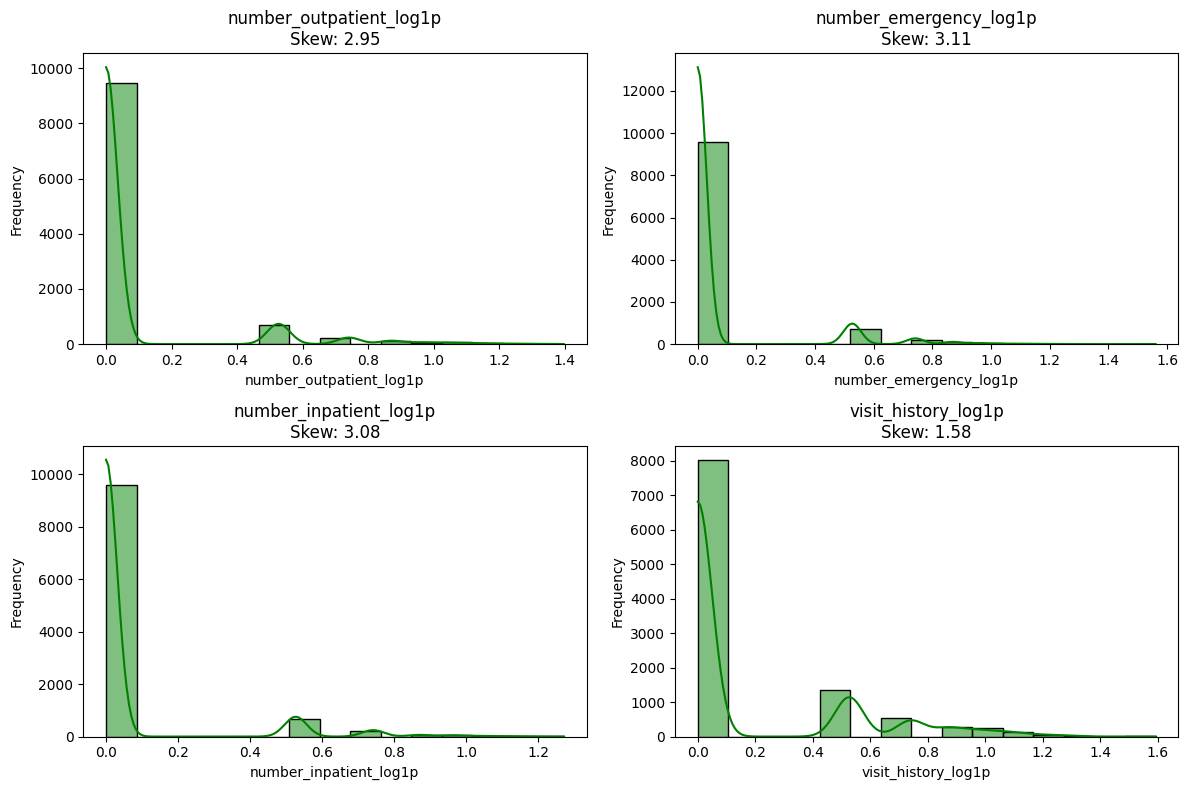

In [ ]:
# visualize log-transformed columns
transformed_cols = ['number_outpatient_log1p', 'number_emergency_log1p',
                    'number_inpatient_log1p', 'visit_history_log1p']

ncols = 2
nrows = int(np.ceil(len(transformed_cols) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, nrows * 4))

axes = axes.flatten()

for idx, col in enumerate(transformed_cols):
    sns.histplot(df[col], kde=True, ax=axes[idx], color='green')
    axes[idx].set_title(f"{col}\nSkew: {df[col].skew():.2f}")
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel("Frequency")

for j in range(idx + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


### **Convert data type**

In [ ]:
# convert data type of nominal features in dataframe to 'object' type
o = ['gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
     'chronic_risk','age', 'diag_1', 'diag_2', 'diag_3']

# Apply conversion
df[o] = df[o].astype('object')

In [ ]:
# Convert encoded medication columns and A1Cresult to integer type
o = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
    'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol',
    'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone'
]

# Convert all these medication-related columns to int
df[o] = df[o].astype('int64')

# Check data types to confirm
df.dtypes

,0
encounter_id,int64
patient_nbr,int64
race,object
gender,object
age,object
admission_type_id,object
discharge_disposition_id,object
admission_source_id,object
time_in_hospital,int64
num_lab_procedures,int64


### **Interaction Terms Features**

In [ ]:
# Define interaction terms
interaction_terms = [
    ('num_medications', 'number_diagnoses'),
    ('num_medications', 'time_in_hospital'),
    ('num_medications', 'change'),
    ('num_medications', 'medch'),
    ('time_in_hospital', 'num_lab_procedures'),
    ('change', 'diabetesMed'),
    ('chronic_risk', 'age')
]

# Create interaction terms in df
for feat1, feat2 in interaction_terms:
    if feat1 in df.columns and feat2 in df.columns:
        df[f'{feat1}|{feat2}'] = df[feat1] * df[feat2]


In [ ]:
df[['num_medications','change', 'num_medications|change']].head()

,num_medications,change,num_medications|change
4,8,1,8
10,17,0,0
12,15,1,15
2,13,0,0
28,20,1,20


### **Store numerical statistics**

In [ ]:
# Define the list of numeric columns based on the provided feature list
num_cols = [
    'number_outpatient_log1p',
    'medch',
    'number_emergency_log1p',
    'number_inpatient_log1p',
    'num_medications',
    'number_diagnoses',
    'visit_history_log1p',
    'time_in_hospital',
    'num_procedures',
    'num_lab_procedures'
]

# Check detected numeric columns
print("Numeric columns for analysis:")
print(num_cols)


Numeric columns for analysis:
['number_outpatient_log1p', 'medch', 'number_emergency_log1p', 'number_inpatient_log1p', 'num_medications', 'number_diagnoses', 'visit_history_log1p', 'time_in_hospital', 'num_procedures', 'num_lab_procedures']


In [ ]:
# Create a DataFrame to store statistics
summary_stats = pd.DataFrame()
summary_stats['Feature'] = num_cols

# Compute standard deviation and mean for each numeric column
summary_stats['Standard Deviation'] = summary_stats['Feature'].apply(lambda col: df[col].std())
summary_stats['Mean'] = summary_stats['Feature'].apply(lambda col: df[col].mean())

# Step 4: Display the result
print(summary_stats)

                   Feature  Standard Deviation       Mean
0  number_outpatient_log1p            0.223699   0.075939
1                    medch            0.508446   0.323071
2   number_emergency_log1p            0.193951   0.062079
3   number_inpatient_log1p            0.196479   0.063071
4          num_medications            7.876253  14.173925
5         number_diagnoses            2.191399   6.477567
6      visit_history_log1p            0.318839   0.172371
7         time_in_hospital            2.708289   3.756617
8           num_procedures            1.647493   1.292942
9       num_lab_procedures           20.458498  42.699174


In [ ]:
# Only consider numeric columns for standard deviation
zero_var_cols = df.select_dtypes(include='number').columns[df.select_dtypes(include='number').std() == 0]

### **Listed Color Map**

In [ ]:
# Drop zero-variance numeric columns
df.drop(columns=zero_var_cols, inplace=True)

In [ ]:
# Step 1: Create a custom light color gradient
custom_cmap = ListedColormap(sns.light_palette((250, 100, 50), input="husl", n_colors=50).as_hex())

# Step 2: Select only numeric columns (excluding patient/encounter ID)
numeric_df = df.select_dtypes(include='number').drop(columns=['patient_nbr', 'encounter_id'], errors='ignore')


# Step 3: Compute correlation matrix
corr_matrix = numeric_df.corr(method='pearson')

# Step 4: Style the correlation matrix with gradient
styled_corr = corr_matrix.style.background_gradient(cmap=custom_cmap, axis=0)

# Display the styled correlation table
styled_corr

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,change,diabetesMed,readmitted,medch,number_outpatient_log1p,number_emergency_log1p,number_inpatient_log1p,visit_history_log1p,num_medications|number_diagnoses,num_medications|time_in_hospital,num_medications|change,num_medications|medch,time_in_hospital|num_lab_procedures,change|diabetesMed
time_in_hospital,1.000000,0.299632,0.183193,0.470888,0.240575,0.028348,0.080118,0.028163,0.031613,0.014729,0.008898,0.012769,0.031197,0.017343,0.008026,0.020140,0.013939,0.017622,0.025914,-0.003625,0.094456,0.007537,-0.006284,0.108936,0.075543,0.048936,0.166518,-0.033336,0.004176,0.062249,0.005661,0.475325,0.833401,0.292004,0.295439,0.861461,0.108936
num_lab_procedures,0.299632,1.000000,0.007207,0.235030,0.137928,-0.069168,0.301882,-0.031253,0.020106,-0.002090,-0.013214,-0.013870,0.039737,0.002071,0.013877,-0.017668,-0.014549,-0.003171,0.011982,0.003837,0.133071,-0.032111,0.000142,0.103562,0.073637,0.041513,0.150022,-0.082969,0.011826,0.092015,-0.011790,0.258703,0.307529,0.182974,0.198349,0.644109,0.103562
num_procedures,0.183193,0.007207,1.000000,0.391605,0.165793,-0.063894,-0.048202,-0.072166,-0.003864,0.003623,-0.000505,-0.001079,-0.001531,0.022162,0.004158,-0.009221,0.012088,-0.003361,-0.007604,0.005377,-0.027866,-0.007504,-0.007604,-0.035914,-0.050711,-0.000856,-0.018749,0.047152,-0.026910,-0.017394,0.006639,0.364744,0.313095,0.160078,0.132696,0.167489,-0.035914
num_medications,0.470888,0.235030,0.391605,1.000000,0.333669,-0.018459,0.009826,0.063174,0.029463,0.021306,-0.002889,0.018274,0.055333,0.047618,0.002246,0.068111,0.050398,0.019771,0.013318,0.004493,0.158005,0.008281,0.009627,0.205574,0.150969,0.052479,0.194656,0.049963,0.035109,0.078642,0.081487,0.898572,0.781007,0.596638,0.488688,0.478825,0.205574
number_diagnoses,0.240575,0.137928,0.165793,0.333669,1.000000,-0.067372,-0.018265,-0.026244,0.017639,0.009552,0.002409,0.005179,0.001655,-0.030583,-0.006533,0.017264,0.010474,0.006475,0.011153,-0.010857,0.043877,0.004084,0.006731,0.046152,0.016628,0.060824,0.061772,0.092684,0.081450,0.104978,0.134346,0.651885,0.281730,0.187288,0.165576,0.239678,0.046152
max_glu_serum,0.028348,-0.069168,-0.063894,-0.018459,-0.067372,1.000000,-0.045528,-0.013072,-0.014277,-0.013644,0.007490,-0.026542,0.011505,-0.016671,-0.001870,-0.019223,0.003494,0.005086,-0.001870,-0.003740,0.018737,-0.015235,-0.001870,0.025054,0.004597,0.007716,0.045544,0.033550,0.031934,0.006065,0.049099,-0.041843,0.006956,0.005224,0.020359,-0.013693,0.025054
A1Cresult,0.080118,0.301882,-0.048202,0.009826,-0.018265,-0.045528,1.000000,0.070711,0.025207,0.009665,-0.001767,0.040487,0.066312,0.021760,-0.005218,0.003656,0.015408,-0.003337,-0.005218,-0.001767,0.165748,-0.030745,-0.005218,0.158756,0.146292,0.004098,0.175263,-0.066136,-0.021384,-0.047187,-0.076898,0.016440,0.055831,0.117159,0.140090,0.186402,0.158756
metformin,0.028163,-0.031253,-0.072166,0.063174,-0.026244,-0.013072,0.070711,1.000000,0.040768,0.046311,-0.010672,0.094170,0.150036,0.193986,-0.005335,0.097188,0.122434,0.012675,-0.005335,0.000794,-0.026643,-0.029322,-0.005335,0.350240,0.316380,-0.024783,0.062525,-0.001171,0.006817,-0.059722,-0.027133,0.033306,0.031449,0.274838,0.071572,-0.000487,0.350240
repaglinide,0.031613,0.020106,-0.003864,0.029463,0.017639,-0.014277,0.025207,0.040768,1.000000,-0.005231,-0.001434,-0.001121,0.001262,-0.009540,-0.000717,-0.002073,0.014959,0.024043,-0.000717,-0.001434,0.015343,-0.005841,-0.000717,0.063295,0.042507,0.003749,0.055854,-0.012950,0.002180,-0.001620,-0.007751,0.032360,0.034757,0.062710,0.060464,0.035936,0.063295
nateglinide,0.014729,-0.002090,0.003623,0.021306,0.009552,-0.013644,0.009665,0.046311,-0.005231,1.000000,-0.001370,-0.006894,-0.009916,-0.008195,-0.000685,0.027963,0.0

### **Encode dummy variables**

In [ ]:
# one-hot encode nominal categorical features
df = pd.get_dummies(df, columns=[
    'gender',
    'admission_type_id',
    'discharge_disposition_id',
    'admission_source_id',
    'diag_1',
    'diag_2',
    'diag_3'
    #'age'
], drop_first=True)

# Encode 'race' separately
df = pd.concat([df, pd.get_dummies(df['race'], prefix='race', drop_first=True)], axis=1)
df.drop(['race'], axis=1, inplace=True)


In [ ]:
print(df.columns)

Index(['encounter_id', 'patient_nbr', 'age', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin', 'change', 'diabetesMed',
       'readmitted', 'medch', 'chronic_risk', 'number_outpatient_log1p',
       'number_emergency_log1p', 'number_inpatient_log1p',
       'visit_history_log1p', 'num_medications|number_diagnoses',
       'num_medications|time_in_hospital', 'num_medications|change',
       'num_medications|medch', 'time_in_hospital|num_lab_procedures',
       'change|diabetesMed', 'chronic_risk|age', 'gender_Male',
       'admission_type_id_3', 'admission_type_id_4', 'admission_type_id_5',
       'discharge_disposition_id

In [ ]:
df = df.drop(columns=['patient_nbr', 'encounter_id'])

In [ ]:
# Convert all boolean columns to integers (0/1)
df = df.astype({col: 'int' for col in df.select_dtypes('bool').columns})

In [ ]:
df

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,...,diag_3_3,diag_3_4,diag_3_5,diag_3_6,diag_3_7,diag_3_8,race_Asian,race_Caucasian,race_Hispanic,race_Other
4,4,1,51,0,8,5,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
10,4,9,47,2,17,9,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
12,4,7,60,0,15,8,0,0,1,1,...,0,1,0,0,0,0,0,1,0,0
2,2,2,11,5,13,6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28,2,10,53,0,20,6,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101740,4,1,1,5,8,4,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
101748,4,14,69,0,16,5,0,2,1,0,...,0,1,0,0,0,0,0,1,0,0
101752,4,3,13,1,5,8,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
101753,4,13,51,2,13,9,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1


# **Modelling**

### **Train-Test split**

In [ ]:
# Step 1: Define target column first
y = df['readmitted'].astype(int)

# Step 2: Drop identifier + target columns from the feature set
X = df.drop(columns=['readmitted','age'])


# === Step 2: Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8523, 80), (2131, 80), (8523,), (2131,))

### **SMOTE (Handle Class Imbalanced)**

Class distribution BEFORE SMOTE:
readmitted
0    7900
1     623
Name: count, dtype: int64


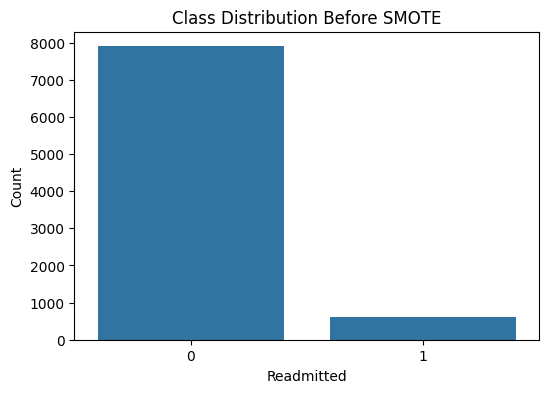

In [ ]:
# Step 3: Show class distribution before SMOTE
print("Class distribution BEFORE SMOTE:")
print(y_train.value_counts())

# Step 4: Visualize class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train)
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Readmitted (0 = No, 1 = Yes)')
plt.xlabel('Readmitted')
plt.ylabel('Count')
plt.show()


In [ ]:
# Apply SMOTE on training data
smt = SMOTE(random_state=42)
X_train_bal, y_train_bal = smt.fit_resample(X_train, y_train)


# Step 6: Verify class distribution after SMOTE
print("\nClass distribution AFTER SMOTE:")
print(pd.Series(y_train_bal).value_counts())


Class distribution AFTER SMOTE:
readmitted
0    7900
1    7900
Name: count, dtype: int64


### **Standardizing**

In [ ]:
# === Step 4: Scale AFTER SMOTE ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# get correct column names from your original X_train
columns = X_train.columns

# recreate dataframe with balanced and scaled
X_train_bal_df = pd.DataFrame(X_train_scaled, columns=columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=columns)

In [ ]:


train_combined = X_train_bal_df.copy()
train_combined['target'] = y_train_bal.values
print("Train combined duplicate rows:", train_combined.duplicated().sum())

test_combined = X_test_scaled_df.copy()
test_combined['target'] = y_test.values
print("Test combined duplicate rows:", test_combined.duplicated().sum())


Train combined duplicate rows: 126
Test combined duplicate rows: 0


## **Feature Importance**

### **Confirmed Features using Gradient Boosting**

In [ ]:
# === Step 5: Train Gradient Boosting to get feature importances ===
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_scaled, y_train_bal)

# Calculate feature importances
importances = pd.Series(gb_model.feature_importances_, index=X.columns)

# === Step 6: Filter confirmed features (threshold = 0.014) ===
threshold = 0.014
importance_df = pd.DataFrame({
    'Variable': importances.index,
    'Importance (Average)': importances.values
})
importance_df['Decision'] = importance_df['Importance (Average)'].apply(
    lambda x: 'Confirmed' if x >= threshold else 'Rejected'
)
importance_df = importance_df.sort_values(by='Importance (Average)', ascending=False).reset_index(drop=True)

# Show full table
print("\n Feature Importance from Gradient Boosting:")
print(importance_df)


 Feature Importance from Gradient Boosting:
                 Variable  Importance (Average)   Decision
0     visit_history_log1p              0.263280  Confirmed
1        chronic_risk|age              0.161892  Confirmed
2                diag_1_4              0.044126  Confirmed
3            chronic_risk              0.040972  Confirmed
4                diag_2_4              0.038190  Confirmed
..                    ...                   ...        ...
75  admission_source_id_9              0.000000   Rejected
76               diag_2_3              0.000000   Rejected
77               diag_2_8              0.000000   Rejected
78               diag_3_5              0.000000   Rejected
79             race_Asian              0.000000   Rejected

[80 rows x 3 columns]


In [ ]:
# === Step 7: Extract and Print Confirmed Features (excluding 'age' optionally)
confirmed_features = importance_df.query("Decision == 'Confirmed'")['Variable'].tolist()


print(f"\n Confirmed Features (Importance ≥ {threshold}) — {len(confirmed_features)} total:")
for feature in confirmed_features:
    print("  -", feature)

# === Step 8: Extract and Print Rejected Features
rejected_features = importance_df.query("Decision == 'Rejected'")['Variable'].tolist()

print(f"\n Rejected Features (Importance < {threshold}) — {len(rejected_features)} total:")
for feature in rejected_features:
    print("  -", feature)



 Confirmed Features (Importance ≥ 0.014) — 19 total:
  - visit_history_log1p
  - chronic_risk|age
  - diag_1_4
  - chronic_risk
  - diag_2_4
  - diag_2_1
  - metformin
  - admission_type_id_3
  - medch
  - diag_3_4
  - number_inpatient_log1p
  - diag_3_1
  - admission_source_id_7
  - num_medications|change
  - num_medications|medch
  - race_Caucasian
  - diag_1_2
  - admission_type_id_5
  - diag_1_3

 Rejected Features (Importance < 0.014) — 61 total:
  - change
  - diag_2_2
  - gender_Male
  - num_medications|number_diagnoses
  - change|diabetesMed
  - admission_source_id_4
  - diag_2_7
  - diag_1_1
  - insulin
  - number_emergency_log1p
  - time_in_hospital|num_lab_procedures
  - diag_3_2
  - diag_1_5
  - num_medications|time_in_hospital
  - diag_1_7
  - A1Cresult
  - diag_1_8
  - race_Hispanic
  - number_outpatient_log1p
  - diag_3_7
  - num_lab_procedures
  - glyburide
  - diag_3_3
  - pioglitazone
  - glipizide
  - num_medications
  - diag_1_6
  - rosiglitazone
  - diag_2_6
  - d

### **Ranked the Top 15 using Random Forest**

/tmp/ipython-input-66-3348531843.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rf_importances.values, y=rf_importances.index, palette='Greens_r')


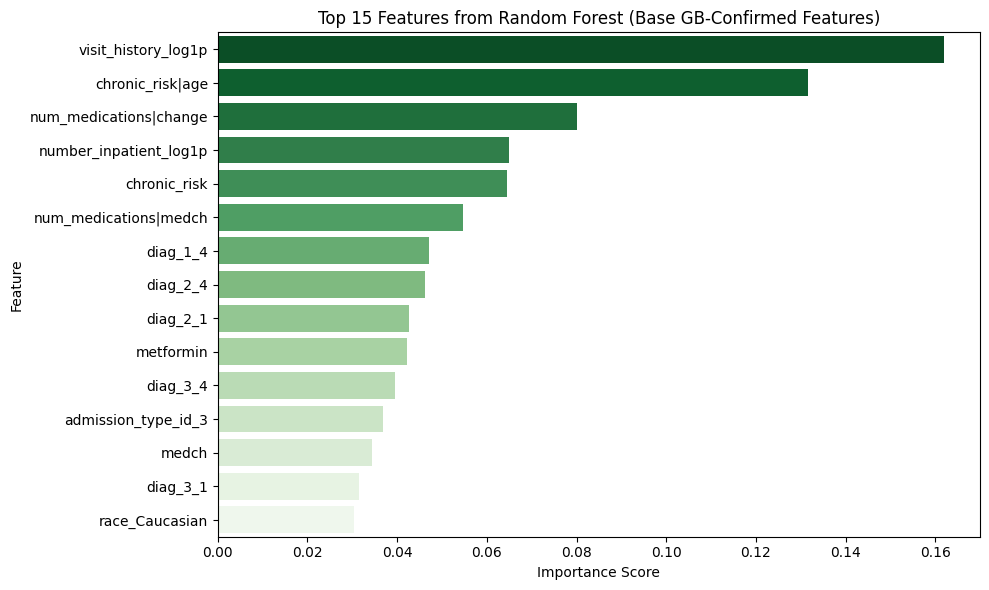


 Selected Top Features from Random Forest (df):
  - visit_history_log1p
  - chronic_risk|age
  - num_medications|change
  - number_inpatient_log1p
  - chronic_risk
  - num_medications|medch
  - diag_1_4
  - diag_2_4
  - diag_2_1
  - metformin
  - diag_3_4
  - admission_type_id_3
  - medch
  - diag_3_1
  - race_Caucasian


In [ ]:
# === Step 5: Train Random Forest on all confirmed features ===
# Assumes 'confirmed_features' was obtained from GB feature selection earlier
X_rf_selected_train = pd.DataFrame(X_train_scaled, columns=X.columns)[confirmed_features]
X_rf_selected_scaled = scaler.fit_transform(X_rf_selected_train)

rf_model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
rf_model.fit(X_rf_selected_scaled, y_train_bal)

# === Step 6: Get top 10 feature importances ===
rf_importances = pd.Series(
    rf_model.feature_importances_,
    index=confirmed_features
).sort_values(ascending=False).head(15)

# === Step 7: Plot top 10 features ===
plt.figure(figsize=(10, 6))
sns.barplot(x=rf_importances.values, y=rf_importances.index, palette='Greens_r')
plt.title("Top 15 Features from Random Forest (Base GB-Confirmed Features)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# === Step 8: Save Top Features ===
selected_rf_features = rf_importances.index.tolist()

print("\n Selected Top Features from Random Forest (df):")
for feat in selected_rf_features:
    print("  -", feat)

### **Top 15 using Decision Tree**

/tmp/ipython-input-67-25728618.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dt_importances.values, y=dt_importances.index, palette='Blues_r')


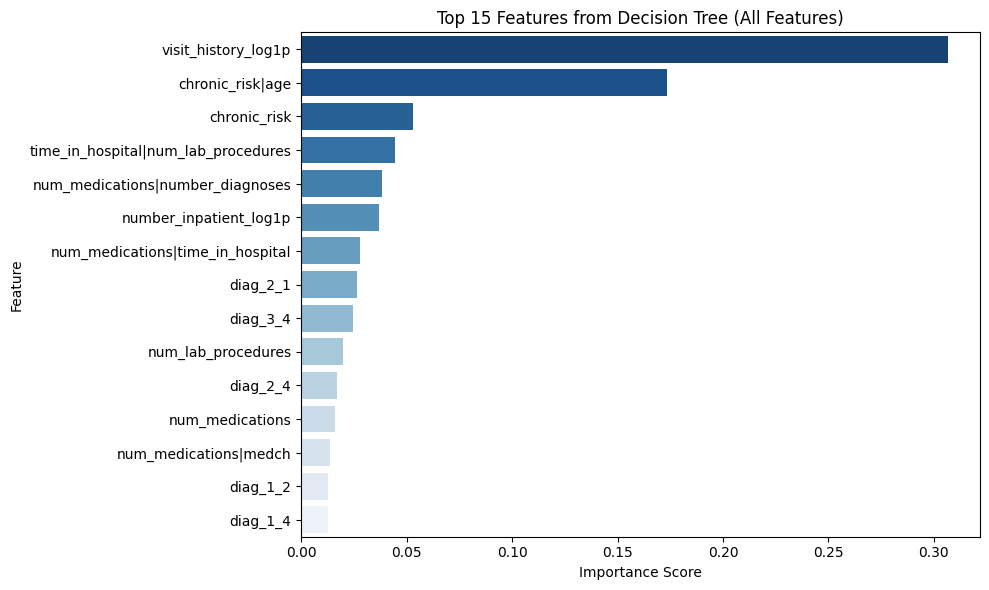


 Selected Top Features from Decision Tree (df):
  - visit_history_log1p
  - chronic_risk|age
  - chronic_risk
  - time_in_hospital|num_lab_procedures
  - num_medications|number_diagnoses
  - number_inpatient_log1p
  - num_medications|time_in_hospital
  - diag_2_1
  - diag_3_4
  - num_lab_procedures
  - diag_2_4
  - num_medications
  - num_medications|medch
  - diag_1_2
  - diag_1_4


In [ ]:
# === Step 5 (DT): Train Decision Tree on all features ===
X_dt_selected_scaled = scaler.fit_transform(X_train_scaled)

dt_model = DecisionTreeClassifier(max_depth=20, random_state=42)
dt_model.fit(X_dt_selected_scaled, y_train_bal)

# === Step 6 (DT): Get top 15 feature importances ===
dt_importances = pd.Series(
    dt_model.feature_importances_,
    index=X.columns
).sort_values(ascending=False).head(15)

# === Step 7: Plot top 15 features from Decision Tree ===
plt.figure(figsize=(10, 6))
sns.barplot(x=dt_importances.values, y=dt_importances.index, palette='Blues_r')
plt.title("Top 15 Features from Decision Tree (All Features)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# === Step 8 (DT): Save Top Features ===
selected_dt_features = dt_importances.index.tolist()

print("\n Selected Top Features from Decision Tree (df):")
for feat in selected_dt_features:
    print("  -", feat)

### **Define the Column**

In [ ]:
# Reapply column names after scaling
original_feature_names = X.columns.tolist()
X_train_bal_df = pd.DataFrame(X_train_scaled, columns=original_feature_names)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)


# Subset by features
X_train_rf = X_train_bal_df[selected_rf_features]
X_test_rf = X_test_scaled_df[selected_rf_features]

# Subset training and test sets for the top 15 Decision Tree features
X_train_dt = X_train_bal_df[selected_dt_features]
X_test_dt = X_test_scaled_df[selected_dt_features]


## **Logistic Regression Model**

In [ ]:
def run_logistic_pipeline(X_train, X_test, y_train, y_test, dataset_name):
    pipeline = ImbPipeline(steps=[
        ('logreg', LogisticRegression(solver='liblinear', max_iter=500))
    ])

    param_grid = {
        'logreg__C': [0.001, 0.01, 0.1, 1, 10],
        'logreg__penalty': ['l1', 'l2'],
        'logreg__class_weight': ['balanced']
    }

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='f1',
        cv=cv,
        verbose=1,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    # get probabilities for test set
    y_probs_test = grid_search.predict_proba(X_test)[:, 1]
    y_probs_train = grid_search.predict_proba(X_train)[:, 1]

    print(f"\n Best Hyperparameters (Logistic Regression): {grid_search.best_params_}")
    print(f"\n Threshold Comparison - {dataset_name}:\n")

    threshold_scores = []
    for t in [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
        y_pred = (y_probs_test >= t).astype(int)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        print(f"Threshold: {t:.2f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f}")
        threshold_scores.append((t, f1))

    # best threshold based on F1
    best_threshold, best_f1 = max(threshold_scores, key=lambda x: x[1])

    # test set
    y_test_pred = (y_probs_test >= best_threshold).astype(int)
    acc_test = accuracy_score(y_test, y_test_pred)
    prec_test = precision_score(y_test, y_test_pred)
    rec_test = recall_score(y_test, y_test_pred)
    f1score_test = f1_score(y_test, y_test_pred)
    auc_test = roc_auc_score(y_test, y_probs_test)

    # train set
    y_train_pred = (y_probs_train >= best_threshold).astype(int)
    acc_train = accuracy_score(y_train, y_train_pred)
    prec_train = precision_score(y_train, y_train_pred)
    rec_train = recall_score(y_train, y_train_pred)
    f1score_train = f1_score(y_train, y_train_pred)
    auc_train = roc_auc_score(y_train, y_probs_train)

    mean_cv_f1 = grid_search.cv_results_['mean_test_score'][grid_search.best_index_]

    print(f"\n Best Threshold: {best_threshold} (F1 Score on test: {best_f1:.4f})")

    print(f"\n--- Logistic Regression Performance on Test Set ({dataset_name}) ---")
    print(f"Accuracy:       {acc_test:.4f}")
    print(f"Precision:      {prec_test:.4f}")
    print(f"Recall:         {rec_test:.4f}")
    print(f"F1 Score:       {f1score_test:.4f}")
    print(f"AUC-ROC Score:  {auc_test:.4f}")
    print(f"Mean 10-Fold CV F1 Score: {mean_cv_f1:.4f}")
    print("\n Full Classification Report (Test):\n", classification_report(y_test, y_test_pred))

    cm_test = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Readmission', 'Readmitted'],
                yticklabels=['No Readmission', 'Readmitted'])
    plt.title(f"Confusion Matrix - Logistic Regression (Test) ({dataset_name})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


    # get classification report as dict to extract weighted average
    report = classification_report(y_test, y_test_pred, output_dict=True)
    weighted_prec = report['weighted avg']['precision']
    weighted_rec = report['weighted avg']['recall']
    weighted_f1 = report['weighted avg']['f1-score']
    acc = report['accuracy']
    auc = roc_auc_score(y_test, y_probs_test)

    # final metrics
    metrics = {
    "Best Threshold": best_threshold,
    "Accuracy": acc,
    "Precision": weighted_prec,
    "Recall": weighted_rec,
    "F1-Score": weighted_f1,
    "AUC-ROC": auc,
    "CV F1-Score": round(mean_cv_f1, 4)
}


    return grid_search, metrics


Fitting 10 folds for each of 10 candidates, totalling 100 fits

✅ Best Hyperparameters (Logistic Regression): {'logreg__C': 0.1, 'logreg__class_weight': 'balanced', 'logreg__penalty': 'l1'}

 Threshold Comparison - Top 15 RF Features:

Threshold: 0.20 | Precision: 0.0693 | Recall: 0.5290 | F1 Score: 0.1225
Threshold: 0.25 | Precision: 0.0678 | Recall: 0.4774 | F1 Score: 0.1188
Threshold: 0.30 | Precision: 0.0705 | Recall: 0.4387 | F1 Score: 0.1215
Threshold: 0.35 | Precision: 0.0799 | Recall: 0.3548 | F1 Score: 0.1305
Threshold: 0.40 | Precision: 0.0811 | Recall: 0.3097 | F1 Score: 0.1285
Threshold: 0.45 | Precision: 0.0794 | Recall: 0.2581 | F1 Score: 0.1214
Threshold: 0.50 | Precision: 0.0912 | Recall: 0.2194 | F1 Score: 0.1288

✅ Best Threshold: 0.35 (F1 Score on test: 0.1305)

--- Logistic Regression Performance on Test Set (Top 15 RF Features) ---
Accuracy:       0.6560
Precision:      0.0799
Recall:         0.3548
F1 Score:       0.1305
AUC-ROC Score:  0.4991
Mean 10-Fold CV F1 S

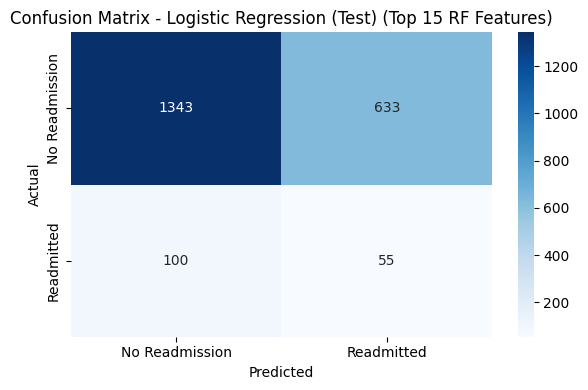


--- Logistic Regression Performance on TRAIN Set (Top 15 RF Features) ---
Accuracy:       0.7853
Precision:      0.7397
Recall:         0.8803
F1 Score:       0.8039
AUC-ROC Score:  0.8803

 Full Classification Report (Train):
               precision    recall  f1-score   support

           0       0.85      0.69      0.76      7900
           1       0.74      0.88      0.80      7900

    accuracy                           0.79     15800
   macro avg       0.80      0.79      0.78     15800
weighted avg       0.80      0.79      0.78     15800



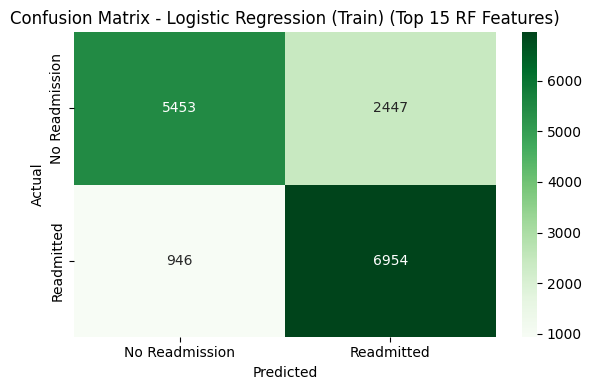

Fitting 10 folds for each of 10 candidates, totalling 100 fits

✅ Best Hyperparameters (Logistic Regression): {'logreg__C': 0.01, 'logreg__class_weight': 'balanced', 'logreg__penalty': 'l1'}

 Threshold Comparison - Top 15 DT Features:

Threshold: 0.20 | Precision: 0.0729 | Recall: 0.8258 | F1 Score: 0.1340
Threshold: 0.25 | Precision: 0.0713 | Recall: 0.7742 | F1 Score: 0.1306
Threshold: 0.30 | Precision: 0.0758 | Recall: 0.6258 | F1 Score: 0.1353
Threshold: 0.35 | Precision: 0.0840 | Recall: 0.4452 | F1 Score: 0.1414
Threshold: 0.40 | Precision: 0.1002 | Recall: 0.3290 | F1 Score: 0.1536
Threshold: 0.45 | Precision: 0.1019 | Recall: 0.2710 | F1 Score: 0.1481
Threshold: 0.50 | Precision: 0.1046 | Recall: 0.2516 | F1 Score: 0.1477

✅ Best Threshold: 0.4 (F1 Score on test: 0.1536)

--- Logistic Regression Performance on Test Set (Top 15 DT Features) ---
Accuracy:       0.7363
Precision:      0.1002
Recall:         0.3290
F1 Score:       0.1536
AUC-ROC Score:  0.5262
Mean 10-Fold CV F1 S

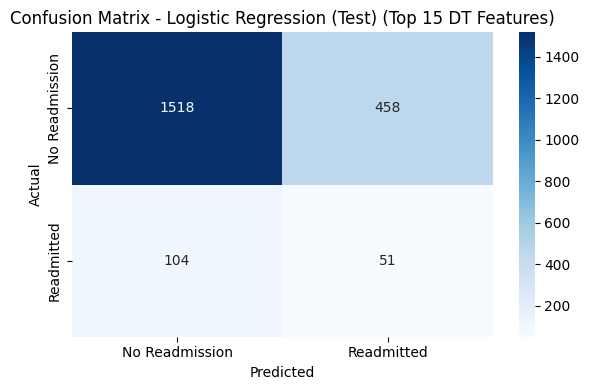


--- Logistic Regression Performance on TRAIN Set (Top 15 DT Features) ---
Accuracy:       0.7931
Precision:      0.7878
Recall:         0.8023
F1 Score:       0.7950
AUC-ROC Score:  0.8363

 Full Classification Report (Train):
               precision    recall  f1-score   support

           0       0.80      0.78      0.79      7900
           1       0.79      0.80      0.79      7900

    accuracy                           0.79     15800
   macro avg       0.79      0.79      0.79     15800
weighted avg       0.79      0.79      0.79     15800



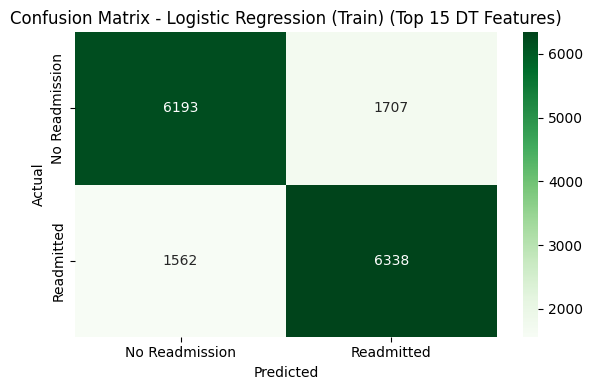

Fitting 10 folds for each of 10 candidates, totalling 100 fits

✅ Best Hyperparameters (Logistic Regression): {'logreg__C': 0.1, 'logreg__class_weight': 'balanced', 'logreg__penalty': 'l1'}

 Threshold Comparison - All Features:

Threshold: 0.20 | Precision: 0.0799 | Recall: 0.3226 | F1 Score: 0.1280
Threshold: 0.25 | Precision: 0.0765 | Recall: 0.2452 | F1 Score: 0.1166
Threshold: 0.30 | Precision: 0.0689 | Recall: 0.1871 | F1 Score: 0.1007
Threshold: 0.35 | Precision: 0.0700 | Recall: 0.1613 | F1 Score: 0.0977
Threshold: 0.40 | Precision: 0.0722 | Recall: 0.1355 | F1 Score: 0.0942
Threshold: 0.45 | Precision: 0.0714 | Recall: 0.1097 | F1 Score: 0.0865
Threshold: 0.50 | Precision: 0.0758 | Recall: 0.0968 | F1 Score: 0.0850

✅ Best Threshold: 0.2 (F1 Score on test: 0.1280)

--- Logistic Regression Performance on Test Set (All Features) ---
Accuracy:       0.6804
Precision:      0.0799
Recall:         0.3226
F1 Score:       0.1280
AUC-ROC Score:  0.5345
Mean 10-Fold CV F1 Score: 0.9017


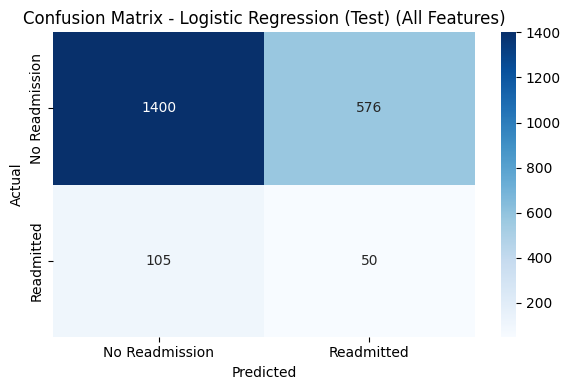


--- Logistic Regression Performance on TRAIN Set (All Features) ---
Accuracy:       0.8287
Precision:      0.7676
Recall:         0.9429
F1 Score:       0.8463
AUC-ROC Score:  0.9502

 Full Classification Report (Train):
               precision    recall  f1-score   support

           0       0.93      0.71      0.81      7900
           1       0.77      0.94      0.85      7900

    accuracy                           0.83     15800
   macro avg       0.85      0.83      0.83     15800
weighted avg       0.85      0.83      0.83     15800



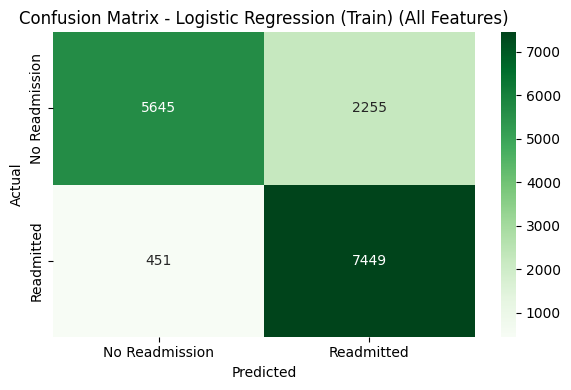

In [ ]:
logreg_grid_rf, metrics_logreg_rf = run_logistic_pipeline(
    X_train_rf, X_test_rf, y_train_bal, y_test,
    dataset_name="Top 15 RF Features"
)
logreg_model_rf = logreg_grid_rf.best_estimator_

logreg_grid_dt, metrics_logreg_dt = run_logistic_pipeline(
    X_train_dt, X_test_dt, y_train_bal, y_test,
    dataset_name="Top 15 DT Features"
)
logreg_model_dt = logreg_grid_dt.best_estimator_

logreg_grid_all, metrics_logreg_all = run_logistic_pipeline(
    X_train_bal_df, X_test_scaled_df, y_train_bal, y_test,
    dataset_name="All Features"
)
logreg_model_all = logreg_grid_all.best_estimator_



## **Decision Tree Model**

In [ ]:
def run_decision_tree_pipeline(X_train, X_test, y_train, y_test, dataset_name):
    pipeline = ImbPipeline(steps=[
        ('dt', DecisionTreeClassifier(random_state=42))
    ])

    param_grid = {
        'dt__max_depth': [5, 10, 15, 20],
        'dt__criterion': ['gini', 'entropy'],
        'dt__class_weight': ['balanced'],
        'dt__min_samples_split': [2, 5, 10],
        'dt__min_samples_leaf': [1, 2, 4]
    }

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='f1',
        cv=cv,
        verbose=1,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    # get probabilities for test and train sets
    y_probs_test = grid_search.predict_proba(X_test)[:, 1]
    y_probs_train = grid_search.predict_proba(X_train)[:, 1]

    print(f"\n Best Hyperparameters (Decision Tree): {grid_search.best_params_}")
    print(f"\n Threshold Comparison - {dataset_name}:\n")

    threshold_scores = []
    for t in [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
        y_pred = (y_probs_test >= t).astype(int)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        print(f"Threshold: {t:.2f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f}")
        threshold_scores.append((t, f1))

    best_threshold, best_f1 = max(threshold_scores, key=lambda x: x[1])

    # TEST set results
    y_test_pred = (y_probs_test >= best_threshold).astype(int)
    acc_test = accuracy_score(y_test, y_test_pred)
    prec_test = precision_score(y_test, y_test_pred)
    rec_test = recall_score(y_test, y_test_pred)
    f1score_test = f1_score(y_test, y_test_pred)
    auc_test = roc_auc_score(y_test, y_probs_test)

    # TRAIN set results
    y_train_pred = (y_probs_train >= best_threshold).astype(int)
    acc_train = accuracy_score(y_train, y_train_pred)
    prec_train = precision_score(y_train, y_train_pred)
    rec_train = recall_score(y_train, y_train_pred)
    f1score_train = f1_score(y_train, y_train_pred)
    auc_train = roc_auc_score(y_train, y_probs_train)

    mean_cv_f1 = grid_search.cv_results_['mean_test_score'][grid_search.best_index_]

    print(f"\n Best Threshold: {best_threshold} (F1 Score on test: {best_f1:.4f})")

    print(f"\n--- Decision Tree Performance on Test Set ({dataset_name}) ---")
    print(f"Accuracy:       {acc_test:.4f}")
    print(f"Precision:      {prec_test:.4f}")
    print(f"Recall:         {rec_test:.4f}")
    print(f"F1 Score:       {f1score_test:.4f}")
    print(f"AUC-ROC Score:  {auc_test:.4f}")
    print(f"Mean 10-Fold CV F1 Score: {mean_cv_f1:.4f}")
    print("\n Full Classification Report (Test):\n", classification_report(y_test, y_test_pred))

    cm_test = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Readmission', 'Readmitted'],
                yticklabels=['No Readmission', 'Readmitted'])
    plt.title(f"Confusion Matrix - Decision Tree (Test) ({dataset_name})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    report = classification_report(y_test, y_test_pred, output_dict=True)
    weighted_prec = report['weighted avg']['precision']
    weighted_rec = report['weighted avg']['recall']
    weighted_f1 = report['weighted avg']['f1-score']
    acc = report['accuracy']
    auc = roc_auc_score(y_test, y_probs_test)



    # final metrics
    metrics = {
    "Best Threshold": best_threshold,
    "Accuracy": acc,
    "Precision": weighted_prec,
    "Recall": weighted_rec,
    "F1-Score": weighted_f1,
    "AUC-ROC": auc,
    "CV F1-Score": round(mean_cv_f1, 4)
}

    return grid_search, metrics


Fitting 10 folds for each of 72 candidates, totalling 720 fits

✅ Best Hyperparameters (Decision Tree): {'dt__class_weight': 'balanced', 'dt__criterion': 'entropy', 'dt__max_depth': 20, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 2}

 Threshold Comparison - Top 15 RF Features:

Threshold: 0.20 | Precision: 0.0754 | Recall: 0.2258 | F1 Score: 0.1131
Threshold: 0.25 | Precision: 0.0854 | Recall: 0.2000 | F1 Score: 0.1197
Threshold: 0.30 | Precision: 0.0903 | Recall: 0.1806 | F1 Score: 0.1204
Threshold: 0.35 | Precision: 0.1076 | Recall: 0.1548 | F1 Score: 0.1270
Threshold: 0.40 | Precision: 0.1106 | Recall: 0.1548 | F1 Score: 0.1290
Threshold: 0.45 | Precision: 0.1236 | Recall: 0.1419 | F1 Score: 0.1321
Threshold: 0.50 | Precision: 0.1236 | Recall: 0.1419 | F1 Score: 0.1321

✅ Best Threshold: 0.45 (F1 Score on test: 0.1321)

--- Decision Tree Performance on Test Set (Top 15 RF Features) ---
Accuracy:       0.8644
Precision:      0.1236
Recall:         0.1419
F1 Score:       0.132

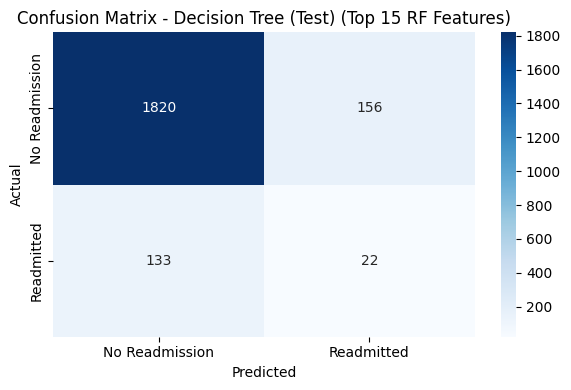

Fitting 10 folds for each of 72 candidates, totalling 720 fits

✅ Best Hyperparameters (Decision Tree): {'dt__class_weight': 'balanced', 'dt__criterion': 'gini', 'dt__max_depth': 20, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 5}

 Threshold Comparison - Top 15 DT Features:

Threshold: 0.20 | Precision: 0.0877 | Recall: 0.2065 | F1 Score: 0.1231
Threshold: 0.25 | Precision: 0.0859 | Recall: 0.2000 | F1 Score: 0.1202
Threshold: 0.30 | Precision: 0.0909 | Recall: 0.1806 | F1 Score: 0.1210
Threshold: 0.35 | Precision: 0.0919 | Recall: 0.1677 | F1 Score: 0.1187
Threshold: 0.40 | Precision: 0.0932 | Recall: 0.1677 | F1 Score: 0.1198
Threshold: 0.45 | Precision: 0.0932 | Recall: 0.1677 | F1 Score: 0.1198
Threshold: 0.50 | Precision: 0.0906 | Recall: 0.1613 | F1 Score: 0.1160

✅ Best Threshold: 0.2 (F1 Score on test: 0.1231)

--- Decision Tree Performance on Test Set (Top 15 DT Features) ---
Accuracy:       0.7860
Precision:      0.0877
Recall:         0.2065
F1 Score:       0.1231
AU

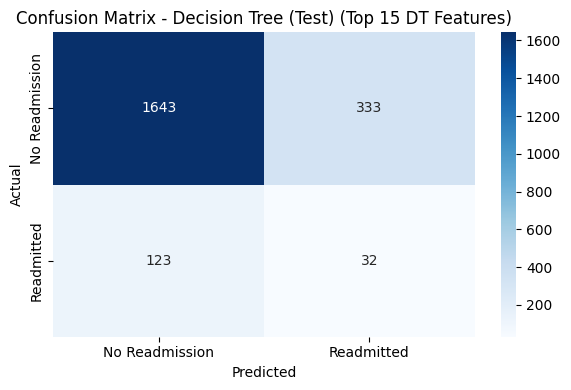

Fitting 10 folds for each of 72 candidates, totalling 720 fits

✅ Best Hyperparameters (Decision Tree): {'dt__class_weight': 'balanced', 'dt__criterion': 'entropy', 'dt__max_depth': 20, 'dt__min_samples_leaf': 4, 'dt__min_samples_split': 10}

 Threshold Comparison - All Features:

Threshold: 0.20 | Precision: 0.0842 | Recall: 0.2065 | F1 Score: 0.1196
Threshold: 0.25 | Precision: 0.0879 | Recall: 0.2065 | F1 Score: 0.1233
Threshold: 0.30 | Precision: 0.0875 | Recall: 0.1677 | F1 Score: 0.1150
Threshold: 0.35 | Precision: 0.0962 | Recall: 0.1613 | F1 Score: 0.1205
Threshold: 0.40 | Precision: 0.0957 | Recall: 0.1419 | F1 Score: 0.1143
Threshold: 0.45 | Precision: 0.0952 | Recall: 0.1161 | F1 Score: 0.1047
Threshold: 0.50 | Precision: 0.0952 | Recall: 0.1161 | F1 Score: 0.1047

✅ Best Threshold: 0.25 (F1 Score on test: 0.1233)

--- Decision Tree Performance on Test Set (All Features) ---
Accuracy:       0.7865
Precision:      0.0879
Recall:         0.2065
F1 Score:       0.1233
AUC-ROC S

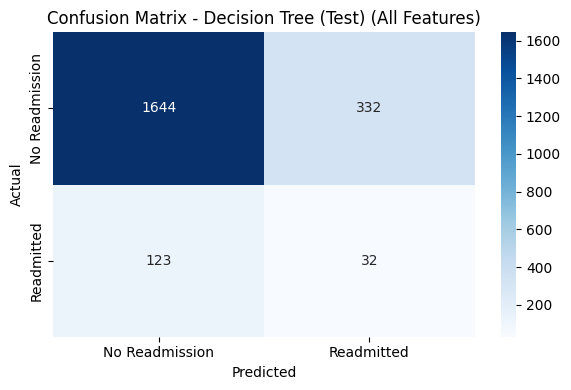

In [ ]:
# Top 15 RF Features
dt_grid_rf, metrics_dt_rf = run_decision_tree_pipeline(
    X_train_rf, X_test_rf, y_train_bal, y_test,
    dataset_name="Top 15 RF Features"
)
dt_model_rf = dt_grid_rf.best_estimator_

# Top 15 DT Features
dt_grid_dt, metrics_dt_dt = run_decision_tree_pipeline(
    X_train_dt, X_test_dt, y_train_bal, y_test,
    dataset_name="Top 15 DT Features"
)
dt_model_dt = dt_grid_dt.best_estimator_

# All Features
dt_grid_all, metrics_dt_all = run_decision_tree_pipeline(
    X_train_bal_df, X_test_scaled_df, y_train_bal, y_test,
    dataset_name="All Features"
)
dt_model_all = dt_grid_all.best_estimator_


## **Random Forest Model**

In [ ]:
def run_random_forest_pipeline(X_train, X_test, y_train, y_test, dataset_name):
    pipeline = ImbPipeline(steps=[
        ('rf', RandomForestClassifier(random_state=42))
    ])

    param_grid = {
        'rf__n_estimators': [100, 200],
        'rf__max_depth': [10, 20, None],
        'rf__min_samples_split': [2, 5],
        'rf__min_samples_leaf': [1, 2],
        'rf__class_weight': ['balanced']
    }

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        scoring='f1',
        cv=cv,
        verbose=1,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    # probabilities
    y_probs_test = grid_search.predict_proba(X_test)[:, 1]
    y_probs_train = grid_search.predict_proba(X_train)[:, 1]

    print(f"\n Best Hyperparameters (Random Forest): {grid_search.best_params_}")
    print(f"\n Threshold Comparison - {dataset_name}:\n")

    threshold_scores = []
    for t in [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
        y_pred = (y_probs_test >= t).astype(int)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        print(f"Threshold: {t:.2f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f}")
        threshold_scores.append((t, f1))

    best_threshold, best_f1 = max(threshold_scores, key=lambda x: x[1])

    # TEST set results
    y_test_pred = (y_probs_test >= best_threshold).astype(int)
    acc_test = accuracy_score(y_test, y_test_pred)
    prec_test = precision_score(y_test, y_test_pred)
    rec_test = recall_score(y_test, y_test_pred)
    f1score_test = f1_score(y_test, y_test_pred)
    auc_test = roc_auc_score(y_test, y_probs_test)

    # TRAIN set results
    y_train_pred = (y_probs_train >= best_threshold).astype(int)
    acc_train = accuracy_score(y_train, y_train_pred)
    prec_train = precision_score(y_train, y_train_pred)
    rec_train = recall_score(y_train, y_train_pred)
    f1score_train = f1_score(y_train, y_train_pred)
    auc_train = roc_auc_score(y_train, y_probs_train)

    mean_cv_f1 = grid_search.cv_results_['mean_test_score'][grid_search.best_index_]

    print(f"\n Best Threshold: {best_threshold} (F1 Score on test: {best_f1:.4f})")

    print(f"\n--- Random Forest Performance on Test Set ({dataset_name}) ---")
    print(f"Accuracy:       {acc_test:.4f}")
    print(f"Precision:      {prec_test:.4f}")
    print(f"Recall:         {rec_test:.4f}")
    print(f"F1 Score:       {f1score_test:.4f}")
    print(f"AUC-ROC Score:  {auc_test:.4f}")
    print(f"Mean 10-Fold CV F1 Score: {mean_cv_f1:.4f}")
    print("\n Full Classification Report (Test):\n", classification_report(y_test, y_test_pred))

    cm_test = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Readmission', 'Readmitted'],
                yticklabels=['No Readmission', 'Readmitted'])
    plt.title(f"Confusion Matrix - Random Forest (Test) ({dataset_name})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    report = classification_report(y_test, y_test_pred, output_dict=True)
    weighted_prec = report['weighted avg']['precision']
    weighted_rec = report['weighted avg']['recall']
    weighted_f1 = report['weighted avg']['f1-score']
    acc = report['accuracy']
    auc = roc_auc_score(y_test, y_probs_test)


    # return metrics
    metrics = {
    "Best Threshold": best_threshold,
    "Accuracy": acc,
    "Precision": weighted_prec,
    "Recall": weighted_rec,
    "F1-Score": weighted_f1,
    "AUC-ROC": auc,
    "CV F1-Score": round(mean_cv_f1, 4)
}

    return grid_search, metrics


Fitting 10 folds for each of 24 candidates, totalling 240 fits

✅ Best Hyperparameters (Random Forest): {'rf__class_weight': 'balanced', 'rf__max_depth': None, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}

 Threshold Comparison - Top 15 RF Features:

Threshold: 0.20 | Precision: 0.0849 | Recall: 0.2903 | F1 Score: 0.1314
Threshold: 0.25 | Precision: 0.0940 | Recall: 0.2129 | F1 Score: 0.1304
Threshold: 0.30 | Precision: 0.1120 | Recall: 0.1742 | F1 Score: 0.1364
Threshold: 0.35 | Precision: 0.1235 | Recall: 0.1355 | F1 Score: 0.1292
Threshold: 0.40 | Precision: 0.1172 | Recall: 0.1097 | F1 Score: 0.1133
Threshold: 0.45 | Precision: 0.1412 | Recall: 0.0774 | F1 Score: 0.1000
Threshold: 0.50 | Precision: 0.1667 | Recall: 0.0710 | F1 Score: 0.0995

✅ Best Threshold: 0.3 (F1 Score on test: 0.1364)

--- Random Forest Performance on Test Set (Top 15 RF Features) ---
Accuracy:       0.8395
Precision:      0.1120
Recall:         0.1742
F1 Score:       0.1364


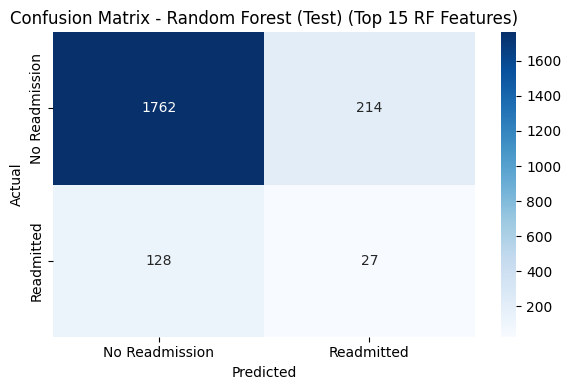

Fitting 10 folds for each of 24 candidates, totalling 240 fits

✅ Best Hyperparameters (Random Forest): {'rf__class_weight': 'balanced', 'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}

 Threshold Comparison - Top 15 DT Features:

Threshold: 0.20 | Precision: 0.1000 | Recall: 0.3032 | F1 Score: 0.1504
Threshold: 0.25 | Precision: 0.1006 | Recall: 0.2129 | F1 Score: 0.1366
Threshold: 0.30 | Precision: 0.0932 | Recall: 0.1419 | F1 Score: 0.1125
Threshold: 0.35 | Precision: 0.1098 | Recall: 0.1161 | F1 Score: 0.1129
Threshold: 0.40 | Precision: 0.1181 | Recall: 0.0968 | F1 Score: 0.1064
Threshold: 0.45 | Precision: 0.1146 | Recall: 0.0710 | F1 Score: 0.0876
Threshold: 0.50 | Precision: 0.0972 | Recall: 0.0452 | F1 Score: 0.0617

✅ Best Threshold: 0.2 (F1 Score on test: 0.1504)

--- Random Forest Performance on Test Set (Top 15 DT Features) ---
Accuracy:       0.7508
Precision:      0.1000
Recall:         0.3032
F1 Score:       0.1504


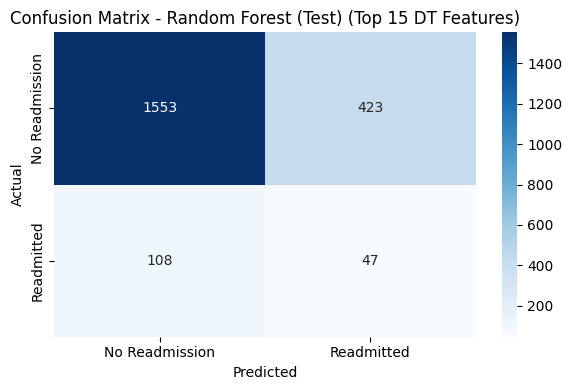

Fitting 10 folds for each of 24 candidates, totalling 240 fits

✅ Best Hyperparameters (Random Forest): {'rf__class_weight': 'balanced', 'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}

 Threshold Comparison - All Features:

Threshold: 0.20 | Precision: 0.1020 | Recall: 0.3032 | F1 Score: 0.1526
Threshold: 0.25 | Precision: 0.1260 | Recall: 0.2065 | F1 Score: 0.1565
Threshold: 0.30 | Precision: 0.1511 | Recall: 0.1355 | F1 Score: 0.1429
Threshold: 0.35 | Precision: 0.1757 | Recall: 0.0839 | F1 Score: 0.1135
Threshold: 0.40 | Precision: 0.2000 | Recall: 0.0516 | F1 Score: 0.0821
Threshold: 0.45 | Precision: 0.3000 | Recall: 0.0387 | F1 Score: 0.0686
Threshold: 0.50 | Precision: 0.3750 | Recall: 0.0194 | F1 Score: 0.0368

✅ Best Threshold: 0.25 (F1 Score on test: 0.1565)

--- Random Forest Performance on Test Set (All Features) ---
Accuracy:       0.8381
Precision:      0.1260
Recall:         0.2065
F1 Score:       0.1565
AUC-ROC Sco

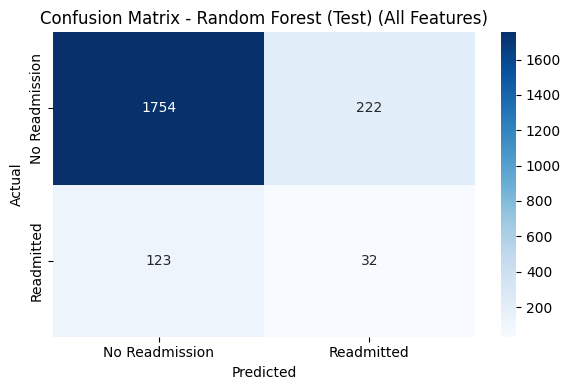

In [ ]:
# === Train RF on Top 15 RF Features ===
rf_grid_rf, metrics_rf_rf = run_random_forest_pipeline(
    X_train_rf, X_test_rf, y_train_bal, y_test,
    dataset_name="Top 15 RF Features"
)
rf_model_rf = rf_grid_rf.best_estimator_

# === Train RF on Top 15 DT Features ===
rf_grid_dt, metrics_rf_dt = run_random_forest_pipeline(
    X_train_dt, X_test_dt, y_train_bal, y_test,
    dataset_name="Top 15 DT Features"
)
rf_model_dt = rf_grid_dt.best_estimator_

# === Train RF on All Features (scaled) ===
rf_grid_all, metrics_rf_all = run_random_forest_pipeline(
    X_train_bal_df, X_test_scaled_df, y_train_bal, y_test,
    dataset_name="All Features"
)
rf_model_all = rf_grid_all.best_estimator_


## **XGBoost Classifiers**

In [ ]:
def run_xgboost_pipeline(X_train, X_test, y_train, y_test, dataset_name):
    pipeline = ImbPipeline(steps=[
        ('xgb', xgb.XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            use_label_encoder=False,
            random_state=42
        ))
    ])

    param_grid = {
        'xgb__n_estimators': [50, 100],
        'xgb__max_depth': [3, 5, 7],
        'xgb__learning_rate': [0.01, 0.1],
        'xgb__scale_pos_weight': [1, 5, 10]
    }

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='f1',
        cv=cv,
        verbose=1,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    # probabilities
    y_probs_test = grid_search.predict_proba(X_test)[:, 1]

    print(f"\n Best Hyperparameters (XGBoost): {grid_search.best_params_}")
    print(f"\n Threshold Comparison - {dataset_name}:\n")

    threshold_scores = []
    for t in [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
        y_pred = (y_probs_test >= t).astype(int)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        print(f"Threshold: {t:.2f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f}")
        threshold_scores.append((t, f1))

    best_threshold, best_f1 = max(threshold_scores, key=lambda x: x[1])

    # TEST set results
    y_test_pred = (y_probs_test >= best_threshold).astype(int)
    acc_test = accuracy_score(y_test, y_test_pred)
    prec_test = precision_score(y_test, y_test_pred)
    rec_test = recall_score(y_test, y_test_pred)
    f1score_test = f1_score(y_test, y_test_pred)
    auc_test = roc_auc_score(y_test, y_probs_test)

    mean_cv_f1 = grid_search.cv_results_['mean_test_score'][grid_search.best_index_]

    print(f"\n Best Threshold: {best_threshold} (F1 Score on test: {best_f1:.4f})")
    print(f"\n--- XGBoost Performance on Test Set ({dataset_name}) ---")
    print(f"Accuracy:       {acc_test:.4f}")
    print(f"Precision:      {prec_test:.4f}")
    print(f"Recall:         {rec_test:.4f}")
    print(f"F1 Score:       {f1score_test:.4f}")
    print(f"AUC-ROC Score:  {auc_test:.4f}")
    print(f"Mean 10-Fold CV F1 Score: {mean_cv_f1:.4f}")
    print("\n Full Classification Report (Test):\n", classification_report(y_test, y_test_pred))

    cm_test = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Readmission', 'Readmitted'],
                yticklabels=['No Readmission', 'Readmitted'])
    plt.title(f"Confusion Matrix - XGBoost (Test) ({dataset_name})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # weighted metrics for TEST to store
    report = classification_report(y_test, y_test_pred, output_dict=True)
    weighted_prec = report['weighted avg']['precision']
    weighted_rec = report['weighted avg']['recall']
    weighted_f1 = report['weighted avg']['f1-score']
    acc = report['accuracy']
    auc = roc_auc_score(y_test, y_probs_test)

    # return metrics for comparison_df
    metrics = {
        "Best Threshold": best_threshold,
        "Accuracy": acc,
        "Precision": weighted_prec,
        "Recall": weighted_rec,
        "F1-Score": weighted_f1,
        "AUC-ROC": auc_test,
        "CV F1-Score": round(mean_cv_f1, 4)
    }

    return grid_search, metrics


Fitting 10 folds for each of 36 candidates, totalling 360 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:33:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 Best Hyperparameters (XGBoost): {'xgb__learning_rate': 0.1, 'xgb__max_depth': 7, 'xgb__n_estimators': 100, 'xgb__scale_pos_weight': 1}

 Threshold Comparison - Top 15 RF Features:

Threshold: 0.20 | Precision: 0.0895 | Recall: 0.2258 | F1 Score: 0.1282
Threshold: 0.25 | Precision: 0.0862 | Recall: 0.1613 | F1 Score: 0.1124
Threshold: 0.30 | Precision: 0.1136 | Recall: 0.1290 | F1 Score: 0.1208
Threshold: 0.35 | Precision: 0.1149 | Recall: 0.1097 | F1 Score: 0.1122
Threshold: 0.40 | Precision: 0.1129 | Recall: 0.0903 | F1 Score: 0.1004
Threshold: 0.45 | Precision: 0.1250 | Recall: 0.0839 | F1 Score: 0.1004
Threshold: 0.50 | Precision: 0.1818 | Recall: 0.0645 | F1 Score: 0.0952

 Best Threshold: 0.2 (F1 Score on test: 0.1282)

--- XGBoost Performance on Test Set (Top 15 RF Features) ---
Accuracy:       0.7766
Precision:      0.0895
Recall:         0.2258
F1 Score:       0.1282
AUC-ROC Score:  0.5155
Mean 10-Fold CV F1 Score: 0.9202

 Full Classification Report (Test):
               pr

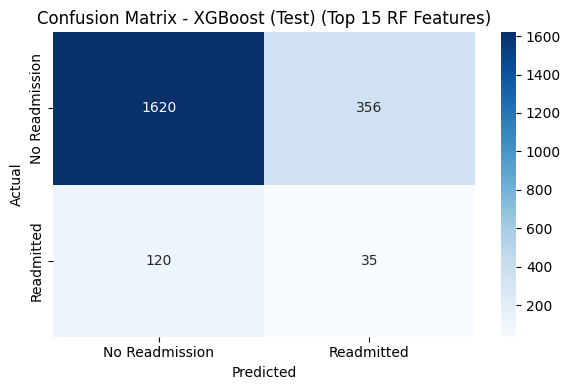

Fitting 10 folds for each of 36 candidates, totalling 360 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:35:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 Best Hyperparameters (XGBoost): {'xgb__learning_rate': 0.1, 'xgb__max_depth': 7, 'xgb__n_estimators': 100, 'xgb__scale_pos_weight': 1}

 Threshold Comparison - Top 15 DT Features:

Threshold: 0.20 | Precision: 0.0873 | Recall: 0.2129 | F1 Score: 0.1238
Threshold: 0.25 | Precision: 0.0871 | Recall: 0.1613 | F1 Score: 0.1131
Threshold: 0.30 | Precision: 0.0813 | Recall: 0.1097 | F1 Score: 0.0934
Threshold: 0.35 | Precision: 0.1000 | Recall: 0.1032 | F1 Score: 0.1016
Threshold: 0.40 | Precision: 0.1102 | Recall: 0.0839 | F1 Score: 0.0952
Threshold: 0.45 | Precision: 0.1087 | Recall: 0.0645 | F1 Score: 0.0810
Threshold: 0.50 | Precision: 0.1194 | Recall: 0.0516 | F1 Score: 0.0721

 Best Threshold: 0.2 (F1 Score on test: 0.1238)

--- XGBoost Performance on Test Set (Top 15 DT Features) ---
Accuracy:       0.7809
Precision:      0.0873
Recall:         0.2129
F1 Score:       0.1238
AUC-ROC Score:  0.5244
Mean 10-Fold CV F1 Score: 0.9391

 Full Classification Report (Test):
               pr

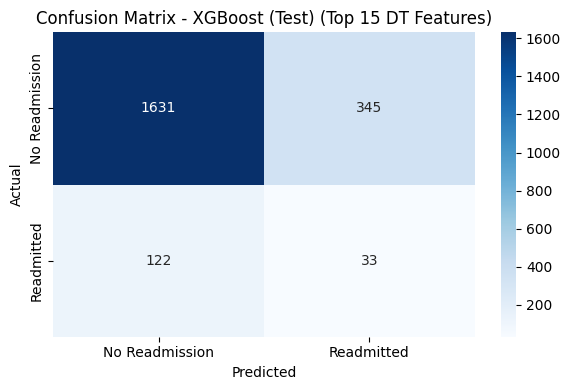

Fitting 10 folds for each of 36 candidates, totalling 360 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 Best Hyperparameters (XGBoost): {'xgb__learning_rate': 0.1, 'xgb__max_depth': 7, 'xgb__n_estimators': 100, 'xgb__scale_pos_weight': 1}

 Threshold Comparison - All Features:

Threshold: 0.20 | Precision: 0.1107 | Recall: 0.2000 | F1 Score: 0.1425
Threshold: 0.25 | Precision: 0.1148 | Recall: 0.1355 | F1 Score: 0.1243
Threshold: 0.30 | Precision: 0.1221 | Recall: 0.1032 | F1 Score: 0.1119
Threshold: 0.35 | Precision: 0.1300 | Recall: 0.0839 | F1 Score: 0.1020
Threshold: 0.40 | Precision: 0.1719 | Recall: 0.0710 | F1 Score: 0.1005
Threshold: 0.45 | Precision: 0.1905 | Recall: 0.0516 | F1 Score: 0.0812
Threshold: 0.50 | Precision: 0.1429 | Recall: 0.0194 | F1 Score: 0.0341

 Best Threshold: 0.2 (F1 Score on test: 0.1425)

--- XGBoost Performance on Test Set (All Features) ---
Accuracy:       0.8250
Precision:      0.1107
Recall:         0.2000
F1 Score:       0.1425
AUC-ROC Score:  0.5591
Mean 10-Fold CV F1 Score: 0.9531

 Full Classification Report (Test):
               precision    r

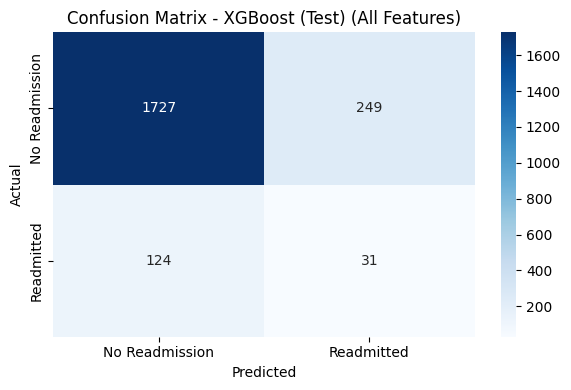

In [ ]:
import xgboost as xgb

xgb_grid_rf, metrics_xgb_rf = run_xgboost_pipeline(
    X_train_rf, X_test_rf, y_train_bal, y_test,
    dataset_name="Top 15 RF Features"
)
xgb_model_rf = xgb_grid_rf.best_estimator_

xgb_grid_dt, metrics_xgb_dt = run_xgboost_pipeline(
    X_train_dt, X_test_dt, y_train_bal, y_test,
    dataset_name="Top 15 DT Features"
)
xgb_model_dt = xgb_grid_dt.best_estimator_

xgb_grid_all, metrics_xgb_all = run_xgboost_pipeline(
    X_train_bal_df, X_test_scaled_df, y_train_bal, y_test,
    dataset_name="All Features"
)
xgb_model_all = xgb_grid_all.best_estimator_


## **Gradient Boosting Classifiers**

In [ ]:
def run_gb_pipeline(X_train, X_test, y_train, y_test, dataset_name):
    pipeline = ImbPipeline(steps=[
        ('gb', GradientBoostingClassifier(random_state=42))
    ])

    param_grid = {
        'gb__n_estimators': [50, 100],
        'gb__max_depth': [3, 5],
        'gb__learning_rate': [0.01, 0.1]
    }

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='f1',
        cv=cv,
        verbose=1,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    # get probabilities
    y_probs_test = grid_search.predict_proba(X_test)[:, 1]

    print(f"\n Best Hyperparameters (Gradient Boosting): {grid_search.best_params_}")
    print(f"\n Threshold Comparison - {dataset_name}:\n")

    threshold_scores = []
    for t in [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
        y_pred = (y_probs_test >= t).astype(int)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        print(f"Threshold: {t:.2f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f}")
        threshold_scores.append((t, f1))

    best_threshold, best_f1 = max(threshold_scores, key=lambda x: x[1])

    # TEST set results
    y_test_pred = (y_probs_test >= best_threshold).astype(int)
    acc_test = accuracy_score(y_test, y_test_pred)
    prec_test = precision_score(y_test, y_test_pred)
    rec_test = recall_score(y_test, y_test_pred)
    f1score_test = f1_score(y_test, y_test_pred)
    auc_test = roc_auc_score(y_test, y_probs_test)
    mean_cv_f1 = grid_search.cv_results_['mean_test_score'][grid_search.best_index_]

    print(f"\n Best Threshold: {best_threshold} (F1 Score on test: {best_f1:.4f})")
    print(f"\n--- Gradient Boosting Performance on Test Set ({dataset_name}) ---")
    print(f"Accuracy:       {acc_test:.4f}")
    print(f"Precision:      {prec_test:.4f}")
    print(f"Recall:         {rec_test:.4f}")
    print(f"F1 Score:       {f1score_test:.4f}")
    print(f"AUC-ROC Score:  {auc_test:.4f}")
    print(f"Mean 10-Fold CV F1 Score: {mean_cv_f1:.4f}")
    print("\n Full Classification Report (Test):\n", classification_report(y_test, y_test_pred))

    cm_test = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Readmission', 'Readmitted'],
                yticklabels=['No Readmission', 'Readmitted'])
    plt.title(f"Confusion Matrix - Gradient Boosting (Test) ({dataset_name})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # weighted averages for storage
    report = classification_report(y_test, y_test_pred, output_dict=True)
    weighted_prec = report['weighted avg']['precision']
    weighted_rec = report['weighted avg']['recall']
    weighted_f1 = report['weighted avg']['f1-score']
    acc = report['accuracy']
    auc = roc_auc_score(y_test, y_probs_test)

    metrics = {
        "Best Threshold": best_threshold,
        "Accuracy": acc,
        "Precision": weighted_prec,
        "Recall": weighted_rec,
        "F1-Score": weighted_f1,
        "AUC-ROC": auc_test,
        "CV F1-Score": round(mean_cv_f1, 4)
    }

    return grid_search, metrics


Fitting 10 folds for each of 8 candidates, totalling 80 fits

✅ Best Hyperparameters (Gradient Boosting): {'gb__learning_rate': 0.1, 'gb__max_depth': 5, 'gb__n_estimators': 100}

 Threshold Comparison - Top 15 RF Features:

Threshold: 0.20 | Precision: 0.0783 | Recall: 0.2323 | F1 Score: 0.1171
Threshold: 0.25 | Precision: 0.0920 | Recall: 0.2065 | F1 Score: 0.1272
Threshold: 0.30 | Precision: 0.1034 | Recall: 0.1355 | F1 Score: 0.1173
Threshold: 0.35 | Precision: 0.1184 | Recall: 0.1161 | F1 Score: 0.1173
Threshold: 0.40 | Precision: 0.1061 | Recall: 0.0903 | F1 Score: 0.0976
Threshold: 0.45 | Precision: 0.1507 | Recall: 0.0710 | F1 Score: 0.0965
Threshold: 0.50 | Precision: 0.1695 | Recall: 0.0645 | F1 Score: 0.0935

✅ Best Threshold: 0.25 (F1 Score on test: 0.1272)

--- Gradient Boosting Performance on Test Set (Top 15 RF Features) ---
Accuracy:       0.7940
Precision:      0.0920
Recall:         0.2065
F1 Score:       0.1272
AUC-ROC Score:  0.5120
Mean 10-Fold CV F1 Score: 0.9203



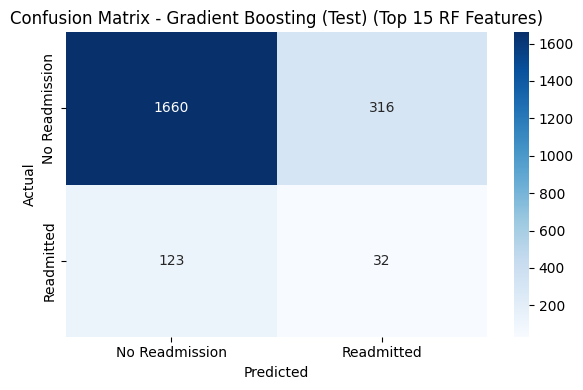

Fitting 10 folds for each of 8 candidates, totalling 80 fits

✅ Best Hyperparameters (Gradient Boosting): {'gb__learning_rate': 0.1, 'gb__max_depth': 5, 'gb__n_estimators': 100}

 Threshold Comparison - Top 15 DT Features:

Threshold: 0.20 | Precision: 0.0913 | Recall: 0.2839 | F1 Score: 0.1381
Threshold: 0.25 | Precision: 0.0951 | Recall: 0.2129 | F1 Score: 0.1315
Threshold: 0.30 | Precision: 0.1090 | Recall: 0.1871 | F1 Score: 0.1378
Threshold: 0.35 | Precision: 0.1078 | Recall: 0.1419 | F1 Score: 0.1226
Threshold: 0.40 | Precision: 0.1090 | Recall: 0.1097 | F1 Score: 0.1093
Threshold: 0.45 | Precision: 0.1316 | Recall: 0.0968 | F1 Score: 0.1115
Threshold: 0.50 | Precision: 0.1370 | Recall: 0.0645 | F1 Score: 0.0877

✅ Best Threshold: 0.2 (F1 Score on test: 0.1381)

--- Gradient Boosting Performance on Test Set (Top 15 DT Features) ---
Accuracy:       0.7424
Precision:      0.0913
Recall:         0.2839
F1 Score:       0.1381
AUC-ROC Score:  0.5366
Mean 10-Fold CV F1 Score: 0.9199

 

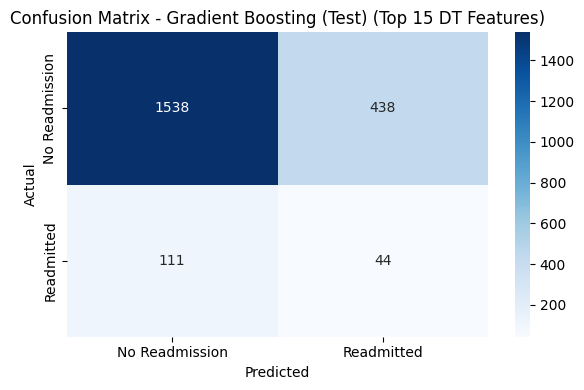

Fitting 10 folds for each of 8 candidates, totalling 80 fits

✅ Best Hyperparameters (Gradient Boosting): {'gb__learning_rate': 0.1, 'gb__max_depth': 5, 'gb__n_estimators': 100}

 Threshold Comparison - All Features:

Threshold: 0.20 | Precision: 0.1042 | Recall: 0.2710 | F1 Score: 0.1505
Threshold: 0.25 | Precision: 0.0915 | Recall: 0.1677 | F1 Score: 0.1185
Threshold: 0.30 | Precision: 0.1129 | Recall: 0.1355 | F1 Score: 0.1232
Threshold: 0.35 | Precision: 0.1349 | Recall: 0.1097 | F1 Score: 0.1210
Threshold: 0.40 | Precision: 0.1705 | Recall: 0.0968 | F1 Score: 0.1235
Threshold: 0.45 | Precision: 0.1509 | Recall: 0.0516 | F1 Score: 0.0769
Threshold: 0.50 | Precision: 0.1875 | Recall: 0.0387 | F1 Score: 0.0642

✅ Best Threshold: 0.2 (F1 Score on test: 0.1505)

--- Gradient Boosting Performance on Test Set (All Features) ---
Accuracy:       0.7776
Precision:      0.1042
Recall:         0.2710
F1 Score:       0.1505
AUC-ROC Score:  0.5583
Mean 10-Fold CV F1 Score: 0.9470

 Full Classif

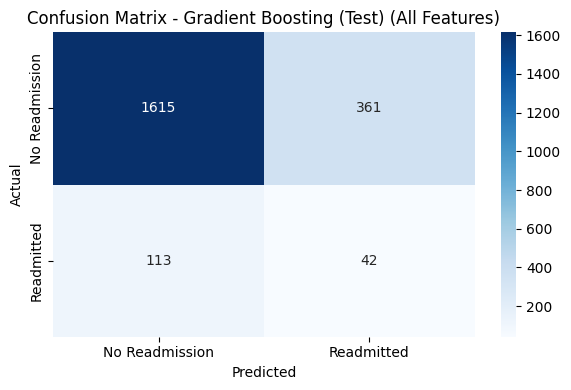

In [ ]:
# Top 15 RF Features
gb_grid_rf, metrics_gb_rf = run_gb_pipeline(
    X_train_rf, X_test_rf, y_train_bal, y_test,
    dataset_name="Top 15 RF Features"
)
gb_model_rf = gb_grid_rf.best_estimator_

# Top 15 DT Features
gb_grid_dt, metrics_gb_dt = run_gb_pipeline(
    X_train_dt, X_test_dt, y_train_bal, y_test,
    dataset_name="Top 15 DT Features"
)
gb_model_dt = gb_grid_dt.best_estimator_

# All Features
gb_grid_all, metrics_gb_all = run_gb_pipeline(
    X_train_bal_df, X_test_scaled_df, y_train_bal, y_test,
    dataset_name="All Features"
)
gb_model_all = gb_grid_all.best_estimator_


# **Result Comparison**

In [ ]:
# gather metrics for each feature set + model
comparison_results = {
    "Feature_Set": [],
    "Model": [],
    "Best Threshold": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": [],
    "AUC-ROC": [],
    "CV F1-Score": []
}

# --- Top 15 RF Features ---
models_rf = [
    ("Logistic Regression", metrics_logreg_rf),
    ("Decision Tree", metrics_dt_rf),
    ("Random Forest", metrics_rf_rf),
    ("XGBoost", metrics_xgb_rf),
    ("Gradient Boosting", metrics_gb_rf)
]

for model_name, metrics in models_rf:
    comparison_results["Feature_Set"].append("Top 15 RF Features")
    comparison_results["Model"].append(model_name)
    comparison_results["Best Threshold"].append(metrics["Best Threshold"])
    comparison_results["Accuracy"].append(metrics["Accuracy"])
    comparison_results["Precision"].append(metrics["Precision"])
    comparison_results["Recall"].append(metrics["Recall"])
    comparison_results["F1-Score"].append(metrics["F1-Score"])
    comparison_results["AUC-ROC"].append(metrics["AUC-ROC"])
    comparison_results["CV F1-Score"].append(metrics["CV F1-Score"])


# --- Top 15 DT Features ---
models_dt = [
    ("Logistic Regression", metrics_logreg_dt),
    ("Decision Tree", metrics_dt_dt),
    ("Random Forest", metrics_rf_dt),
    ("XGBoost", metrics_xgb_dt),
    ("Gradient Boosting", metrics_gb_dt)
]

for model_name, metrics in models_dt:
    comparison_results["Feature_Set"].append("Top 15 DT Features")
    comparison_results["Model"].append(model_name)
    comparison_results["Best Threshold"].append(metrics["Best Threshold"])
    comparison_results["Accuracy"].append(metrics["Accuracy"])
    comparison_results["Precision"].append(metrics["Precision"])
    comparison_results["Recall"].append(metrics["Recall"])
    comparison_results["F1-Score"].append(metrics["F1-Score"])
    comparison_results["AUC-ROC"].append(metrics["AUC-ROC"])
    comparison_results["CV F1-Score"].append(metrics["CV F1-Score"])


# --- All Features ---
models_all = [
    ("Logistic Regression", metrics_logreg_all),
    ("Decision Tree", metrics_dt_all),
    ("Random Forest", metrics_rf_all),
    ("XGBoost", metrics_xgb_all),
    ("Gradient Boosting", metrics_gb_all)
]

for model_name, metrics in models_all:
    comparison_results["Feature_Set"].append("All Features")
    comparison_results["Model"].append(model_name)
    comparison_results["Best Threshold"].append(metrics["Best Threshold"])
    comparison_results["Accuracy"].append(metrics["Accuracy"])
    comparison_results["Precision"].append(metrics["Precision"])
    comparison_results["Recall"].append(metrics["Recall"])
    comparison_results["F1-Score"].append(metrics["F1-Score"])
    comparison_results["AUC-ROC"].append(metrics["AUC-ROC"])
    comparison_results["CV F1-Score"].append(metrics["CV F1-Score"])


# convert to dataframe
comparison_df = pd.DataFrame(comparison_results)
comparison_df


,Feature_Set,Model,Best Threshold,Accuracy,Precision,Recall,F1-Score,AUC-ROC,CV F1-Score
0,Top 15 RF Features,Logistic Regression,0.35,0.656030,0.868819,0.656030,0.737959,0.499068,0.8096
1,Top 15 RF Features,Decision Tree,0.45,0.864383,0.873107,0.864383,0.868669,0.493566,0.9107
2,Top 15 RF Features,Random Forest,0.30,0.839512,0.872614,0.839512,0.855154,0.542793,0.9174
3,Top 15 RF Features,XGBoost,0.20,0.776631,0.869826,0.776631,0.817812,0.515514,0.9202
4,Top 15 RF Features,Gradient Boosting,0.25,0.793993,0.869985,0.793993,0.828227,0.512000,0.9203
5,Top 15 DT Features,Logistic Regression,0.40,0.736274,0.875097,0.736274,0.793601,0.526156,0.7800
6,Top 15 DT Features,Decision Tree,0.20,0.786016,0.869058,0.786016,0.823220,0.518517,0.9222
7,Top 15 DT Features,Random Forest,0.20,0.750821,0.874246,0.750821,0.802824,0.568743,0.9530
8,Top 15 DT Features,XGBoost,0.20,0.780854,0.869081,0.780854,0.820145,0.524386,0.9391
9,Top 15 DT Features,Gradient Boosting,0.20,0.742374,0.871487,0.742374,0.796880,0.536622,0.9199


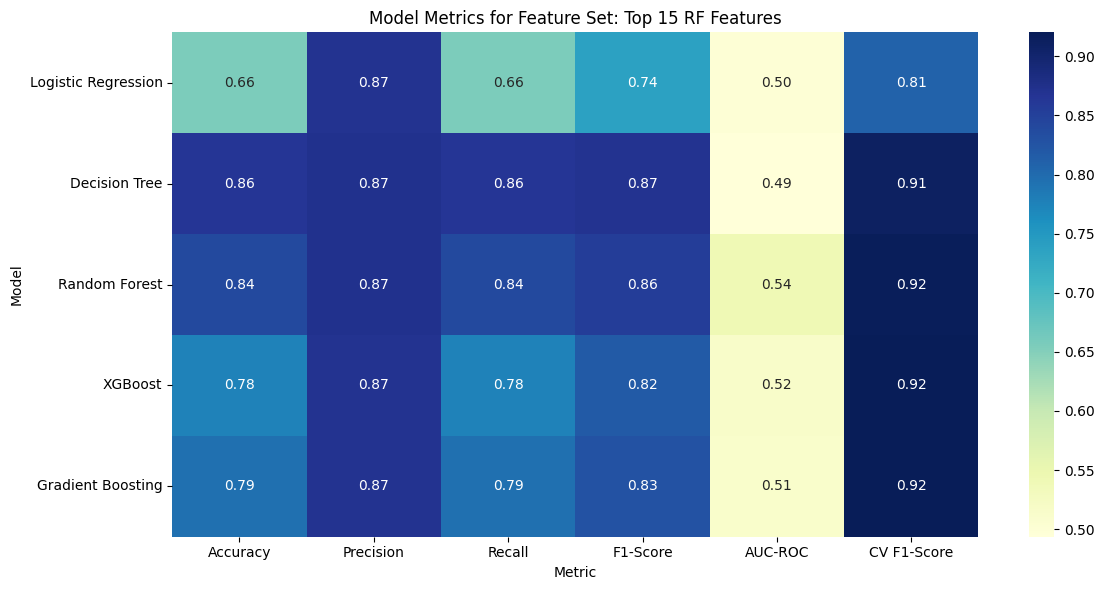

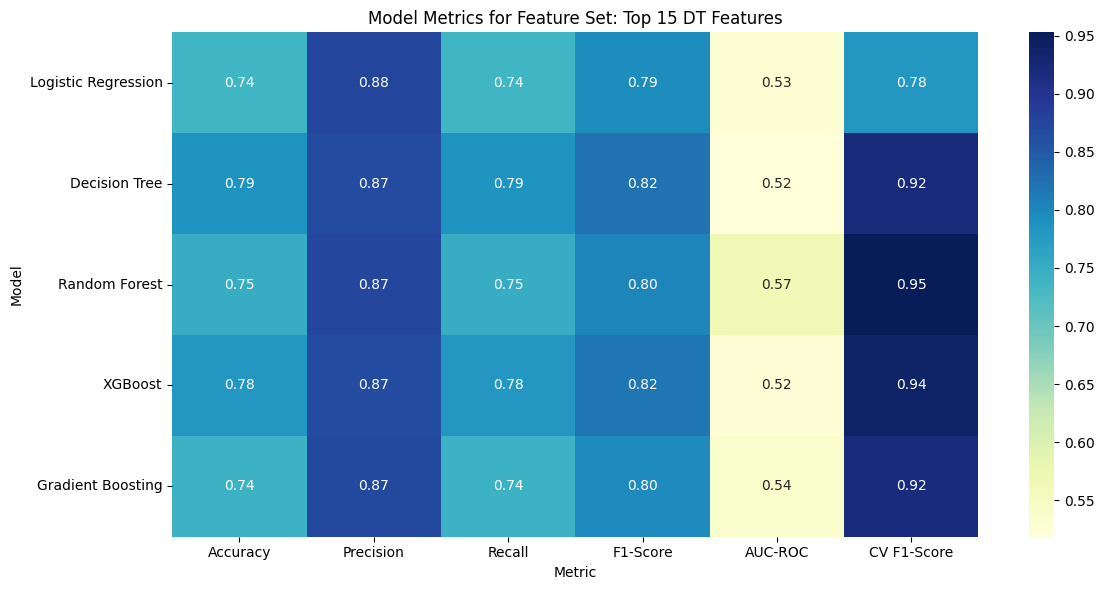

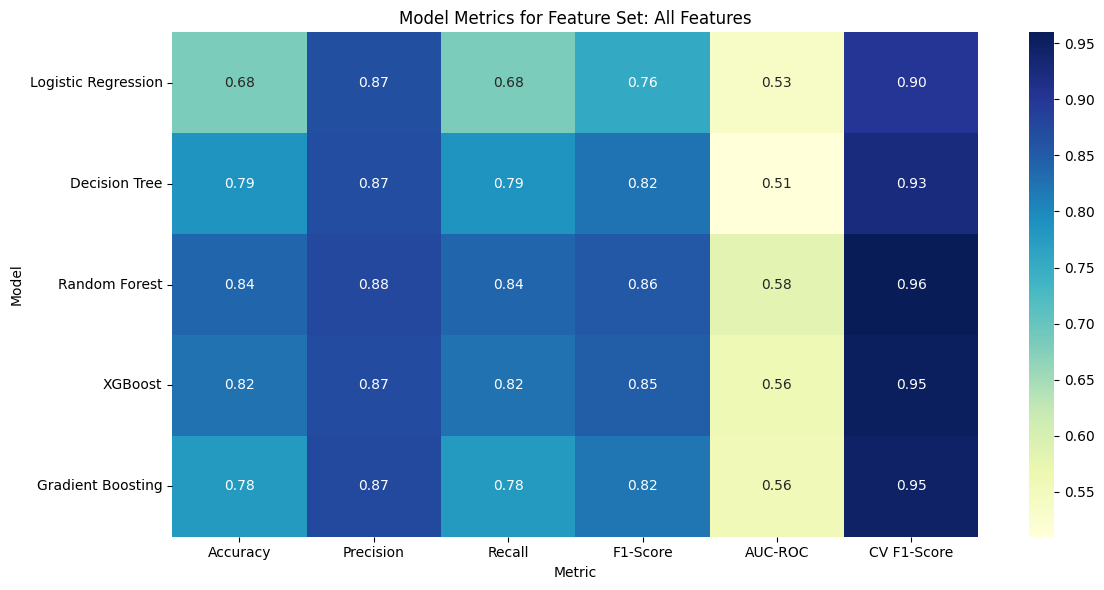

In [ ]:
# which metrics you want to compare in the heatmap
metrics_to_show = ["Accuracy", "Precision", "Recall", "F1-Score", "AUC-ROC", "CV F1-Score"]

# list of feature sets
feature_sets = comparison_df["Feature_Set"].unique()

for featset in feature_sets:
    # filter only that feature set
    data = comparison_df[comparison_df["Feature_Set"] == featset]

    # pivot: rows=Model, columns=Metric
    heatmap_data = data.set_index("Model")[metrics_to_show]

    plt.figure(figsize=(12, 6))
    sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title(f"Model Metrics for Feature Set: {featset}")
    plt.xlabel("Metric")
    plt.ylabel("Model")
    plt.tight_layout()
    plt.show()


## **Save in CSV File**

In [ ]:
# Save to CSV
comparison_df.to_csv('model_comparison_metrics.csv', index=False)


In [ ]:
# Load your raw CSV file
df = pd.read_csv("model_comparison_metrics.csv")  # or use full path

# Convert metric columns to numeric
numeric_cols = ['Best Threshold', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'CV F1-Score']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Save the cleaned CSV
df.to_csv("model_comparison_metrics_clean.csv", index=False)